# The seaborn.objects interface

The `seaborn.objects` namespace was introduced as a interface for making seaborn plots, with increased flexibility. It offers a more consistent and flexible API, comprising a collection of composable classes for transforming and plotting data. In contrast to the existing `seaborn` functions, the new interface aims to support end-to-end plot specification and customization without dropping down to matplotlib (although it will remain possible to do so if necessary).

In [1]:
import seaborn as sns
import matplotlib as mpl
tips = sns.load_dataset("tips")
penguins = sns.load_dataset("penguins").dropna()
diamonds = sns.load_dataset("diamonds")
healthexp = sns.load_dataset("healthexp").sort_values(["Country", "Year"]).query("Year <= 2020")

## Specifying a plot and mapping data

The objects interface should be imported with the following convention:

In [2]:
import seaborn.objects as so

The `seaborn.objects` namespace will provide access to all of the relevant classes. The most important is `Plot`. You specify plots by instantiating a `Plot` object and calling its methods. Let's see a simple example:

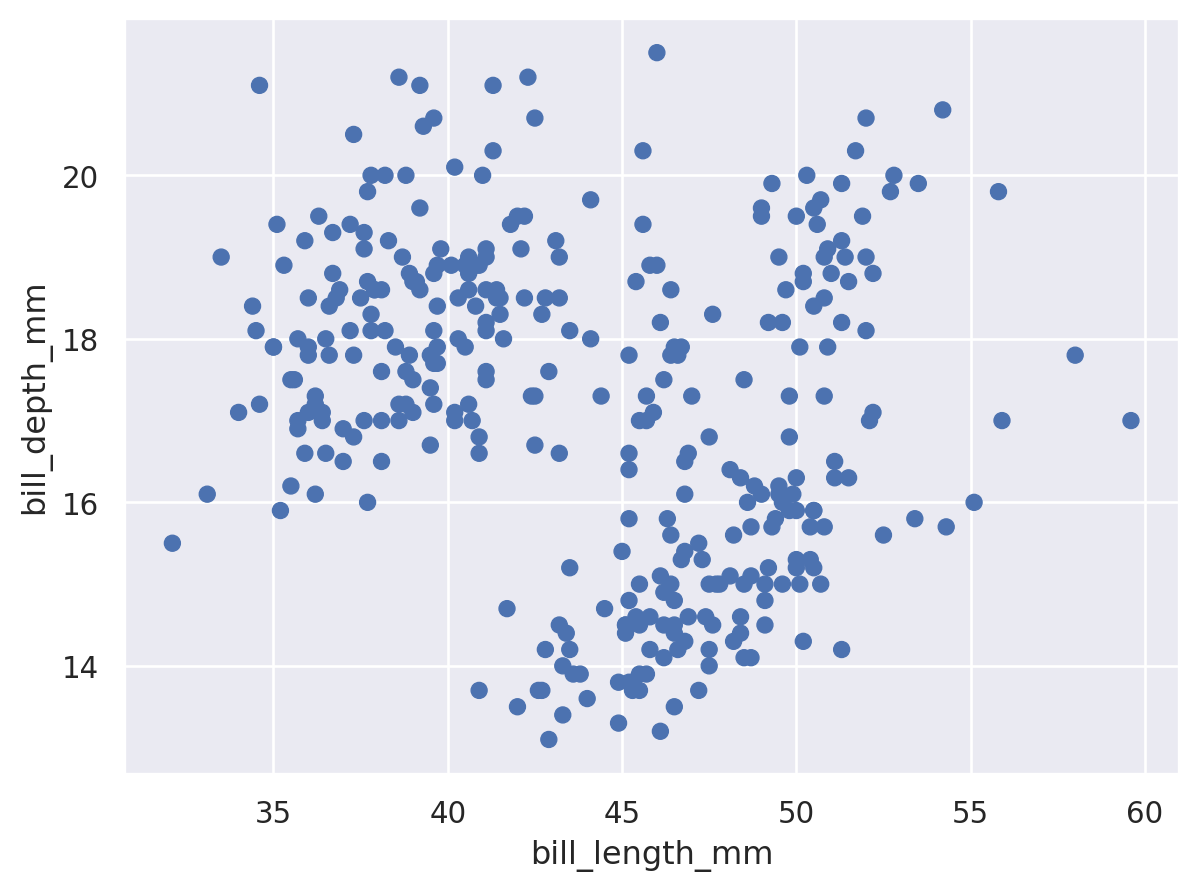

In [3]:
(# Instantiate the Plot object
    so.Plot(penguins,  #same as before, putting data in the Plot object
            x="bill_length_mm", y="bill_depth_mm") #specifying x and y axes here
    .add(so.Dot()) #adding a layer with dots
)

This code, which produces a scatter plot, should look reasonably familiar. Just as when using `seaborn.scatterplot`, we passed a tidy dataframe (`penguins`) and assigned two of its columns to the `x` and `y` coordinates of the plot. But instead of starting with the type of chart and then adding some data assignments, here we started with the data assignments and then added a graphical element.

## Setting properties

The `Dot` class is an example of a `Mark`: an object that graphically represents data values. Each mark will have a number of properties that can be set to change its appearance:

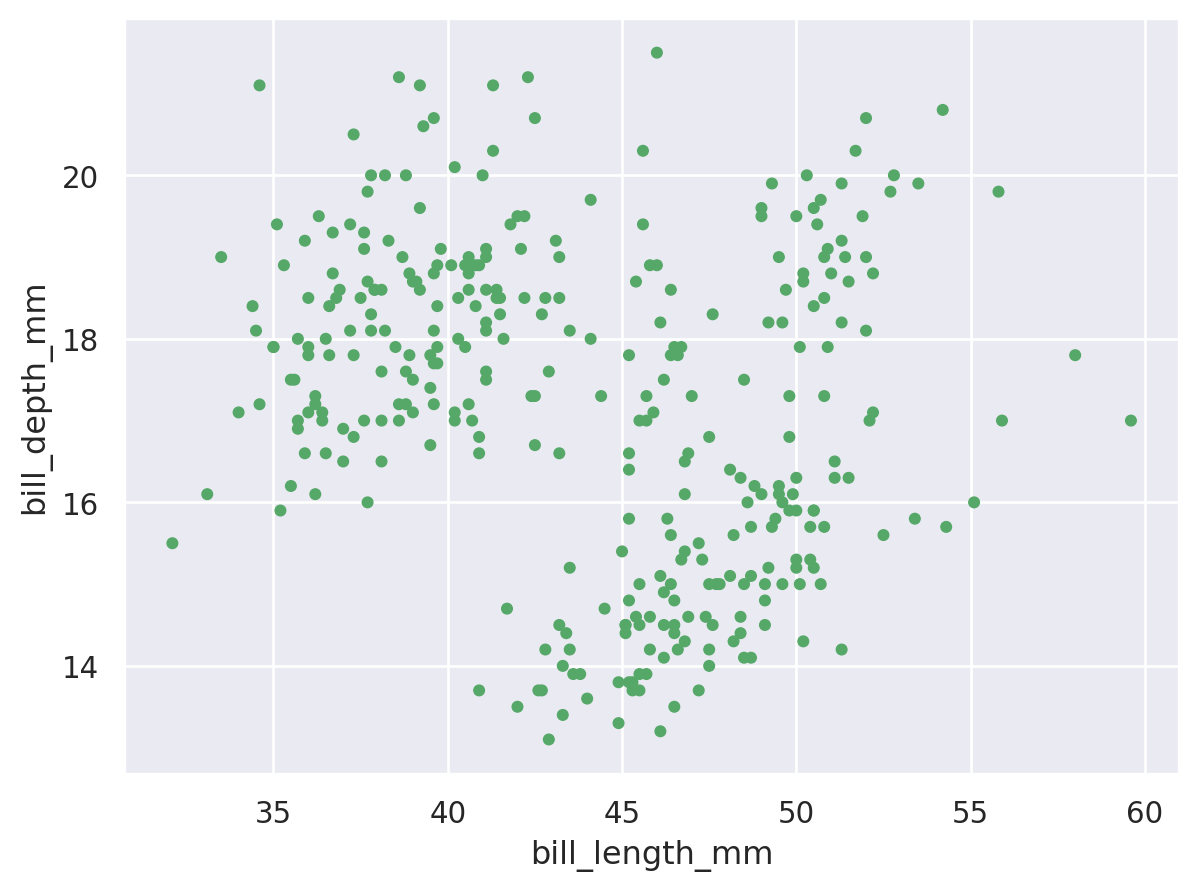

In [4]:
#Create a plot object
(
    so.Plot(penguins, #same as before, putting data in the Plot object
            x="bill_length_mm", y="bill_depth_mm" #specifying x and y axes here
            ).add(so.Dot(color="g", pointsize=4)) #adding a layer with green dots of size 4
)

## Mapping properties

As with seaborn's functions, it is also possible to *map* data values to various graphical properties:

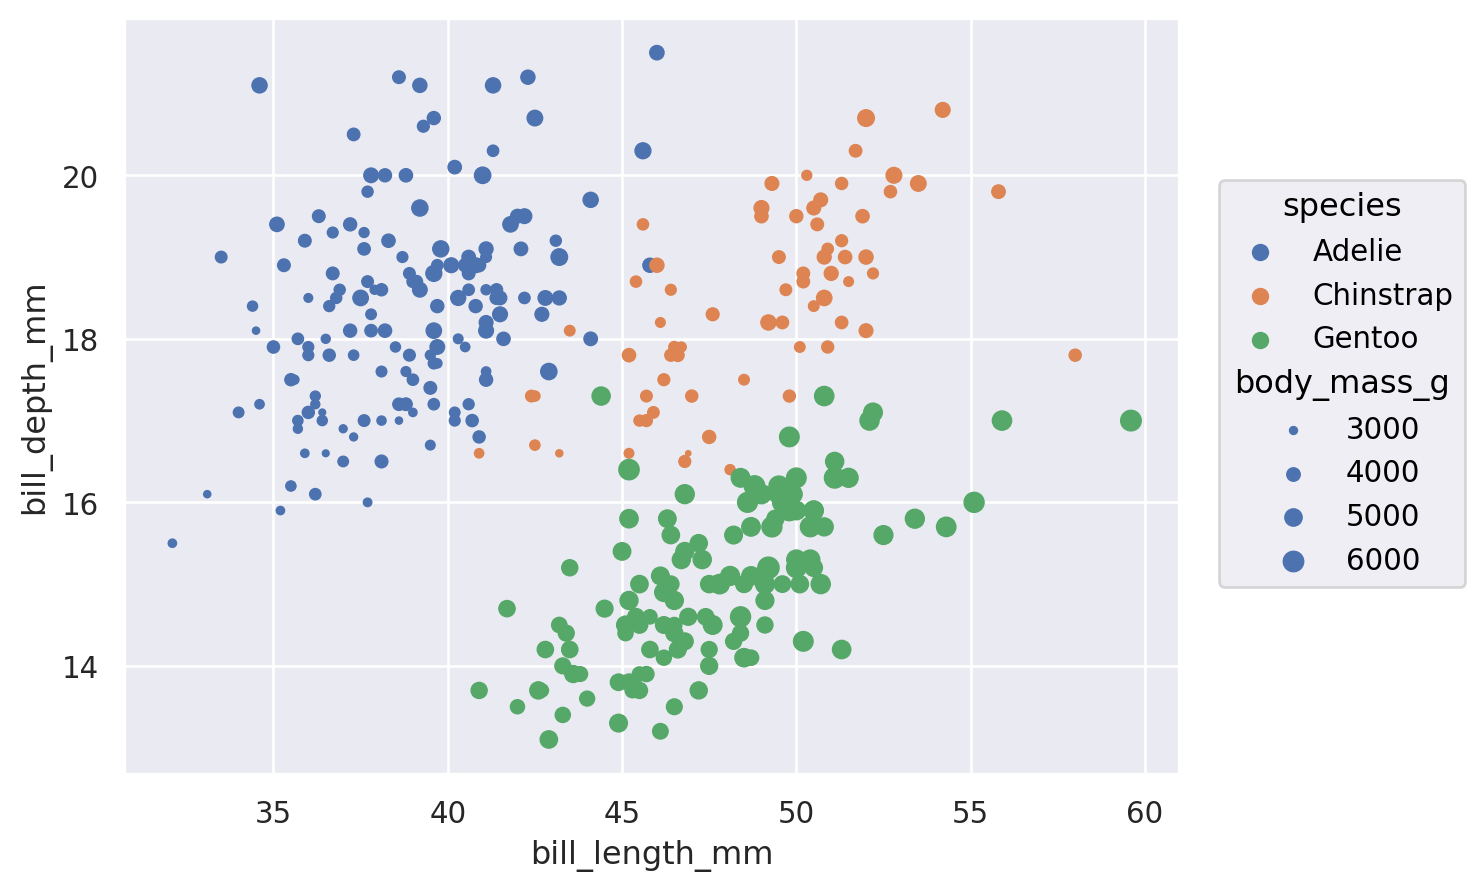

In [5]:
#Create a plot object with color and pointsize mapped to variables
(
    so.Plot(
        penguins, x="bill_length_mm", y="bill_depth_mm", #dataframe, x and y axes
        color="species", pointsize="body_mass_g", #mapping color and pointsize to variables
    )
    .add(so.Dot()) #adding a layer with dots
)

While this basic functionality is not novel, an important difference from the function API is that properties are mapped using the same parameter names that would set them directly (instead of having `hue` vs. `color`, etc.). What matters is *where* the property is defined: passing a value when you initialize `Dot` will set it directly, whereas assigning a variable when you set up the `Plot` will *map* the corresponding data.

Beyond this difference, the objects interface also allows a much wider range of mark properties to be mapped:

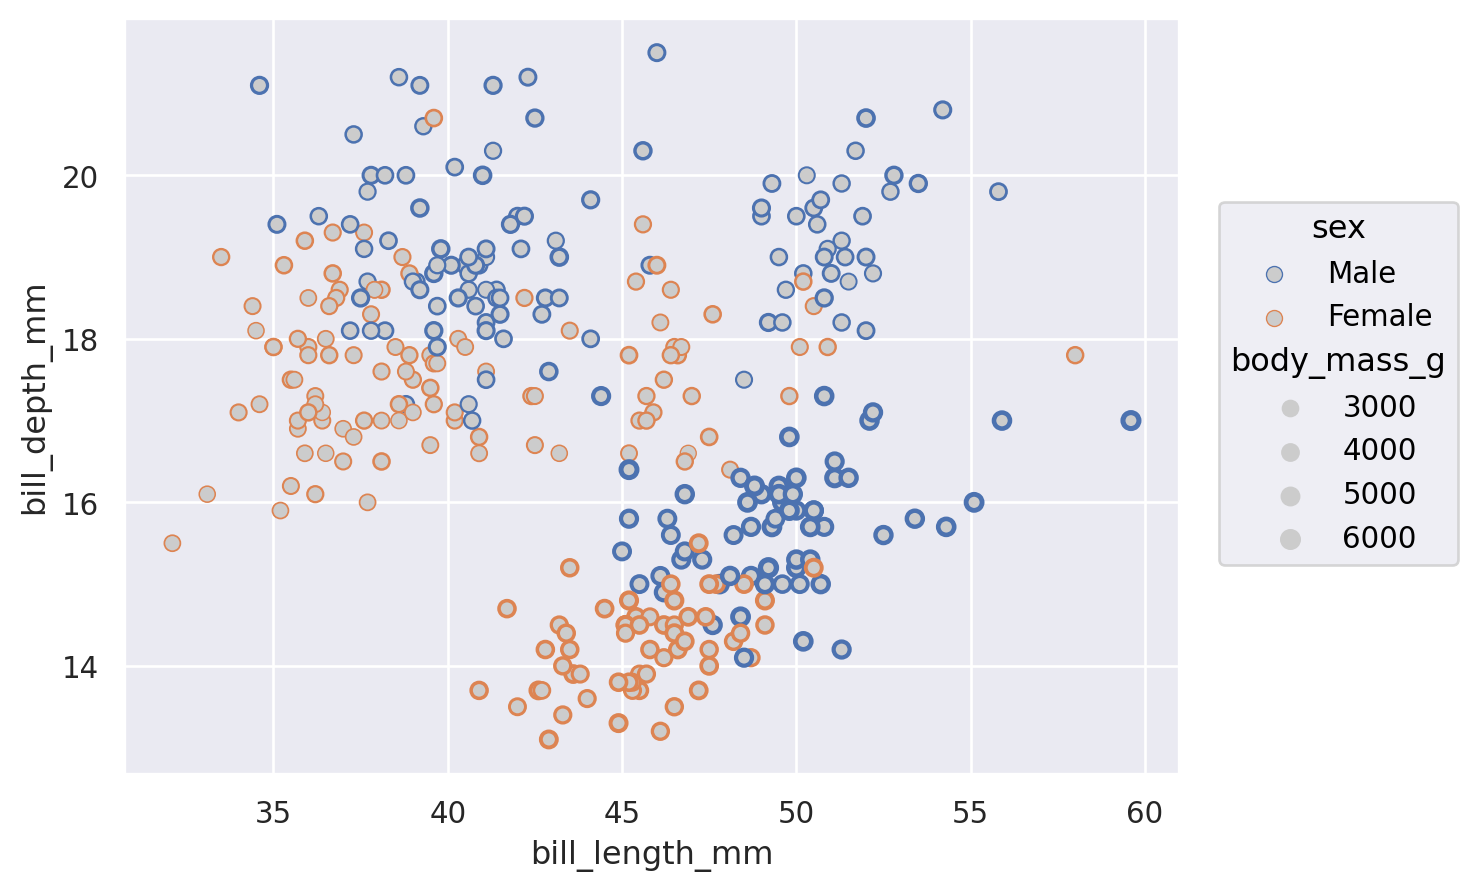

In [6]:
#Create a plot object with edgecolor and edgewidth mapped to variables
(
    so.Plot(
        penguins, x="bill_length_mm", y="bill_depth_mm", #dataframe, x/y axes
        edgecolor="sex", edgewidth="body_mass_g", #mapping edgecolor and edgewidth to variables
    )
    .add(so.Dot(color=".8")) #adding a layer with gray dots, color overridden to gray for the dot fill
)

## Defining groups

The `Dot` mark represents each data point independently, so the assignment of a variable to a property only has the effect of changing each dot's appearance. For marks that group or connect observations, such as `Line`, it also determines the number of distinct graphical elements:

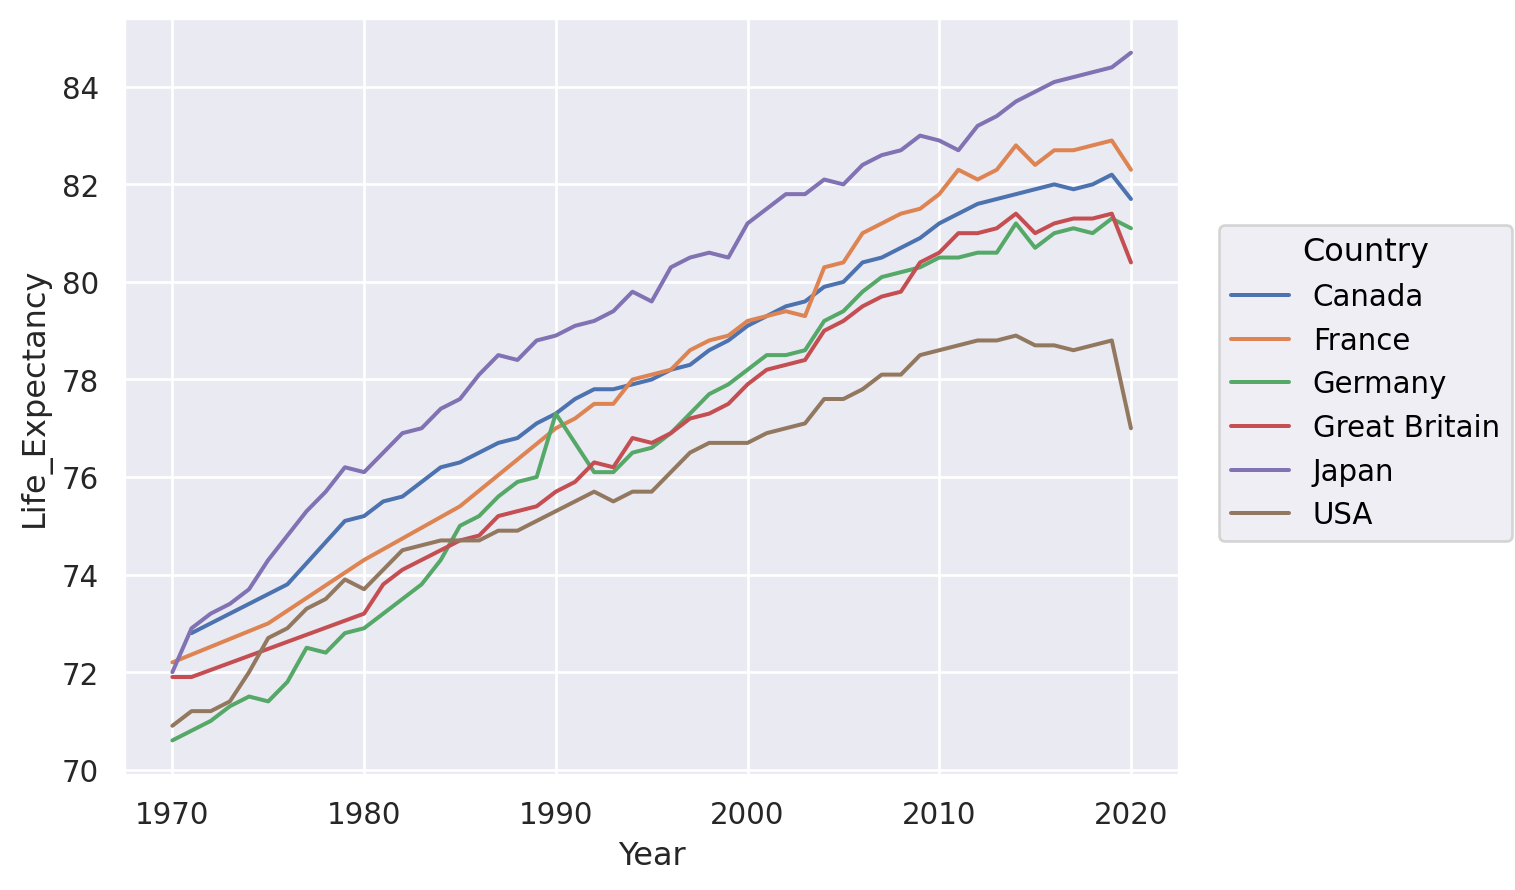

In [7]:
#initiate a plot object for healthexp dataset
(
    so.Plot(healthexp, x="Year", y="Life_Expectancy", #dataframe, x and y axes
            color="Country") #mapping color to Country
    .add(so.Line())
)

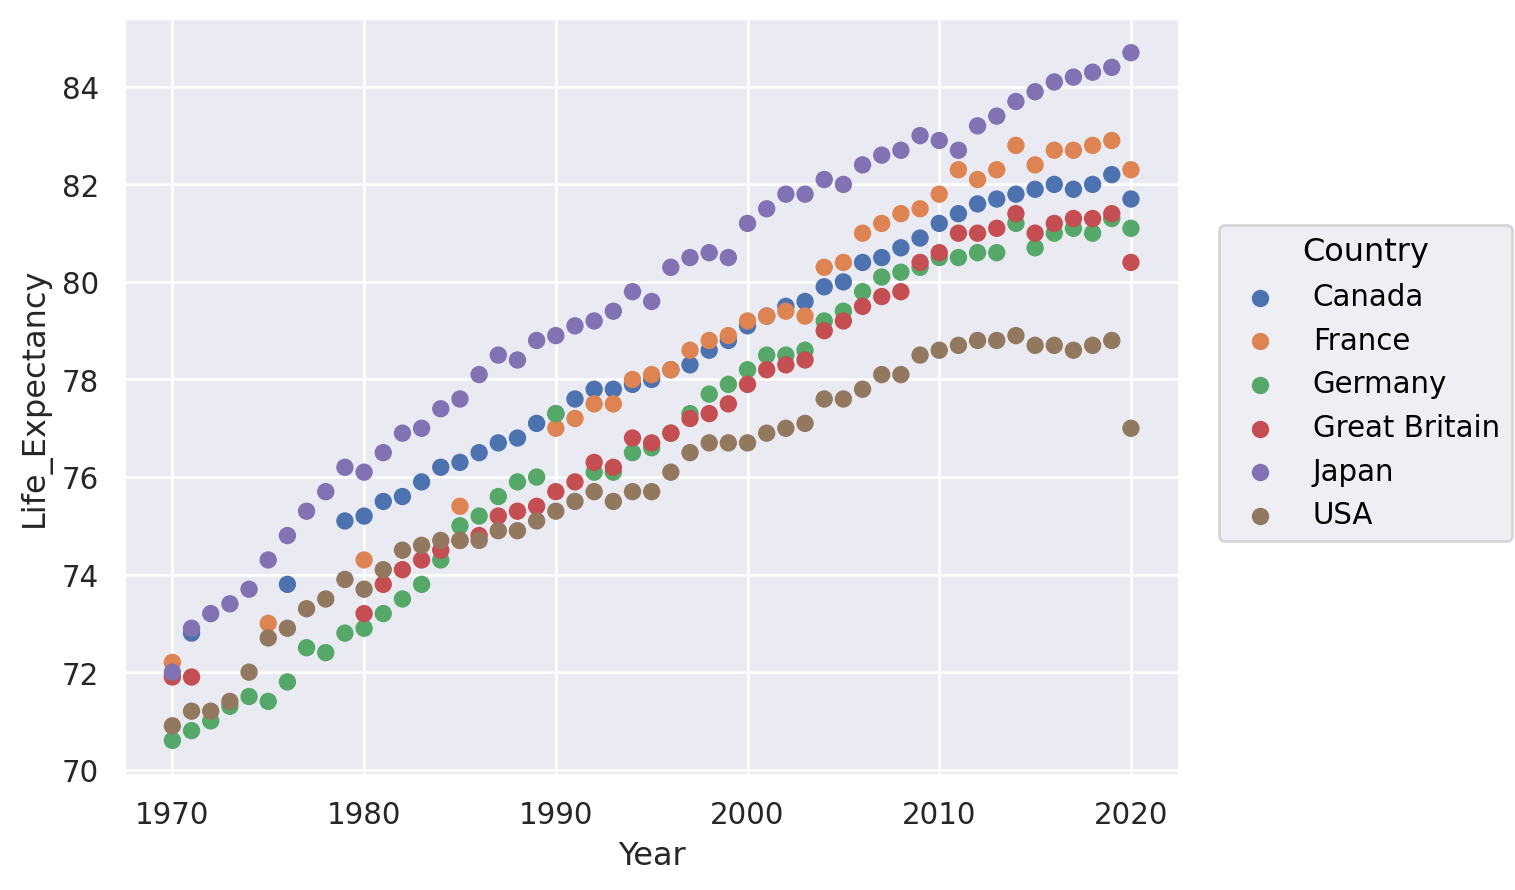

In [ ]:
#adding flexibility to choose plot type, setting plot type variable
#plottype = so.Line()
#plottype = so.Bar()
#plottype = so.Area()
plottype = so.Dot()

#initiate a plot object for healthexp dataset
(
    so.Plot(healthexp, x="Year", y="Life_Expectancy", #dataframe, x and y axes
            color="Country") #mapping color to Country
    .add(plottype)
)

It is also possible to define a grouping without changing any visual properties, by using `group`:

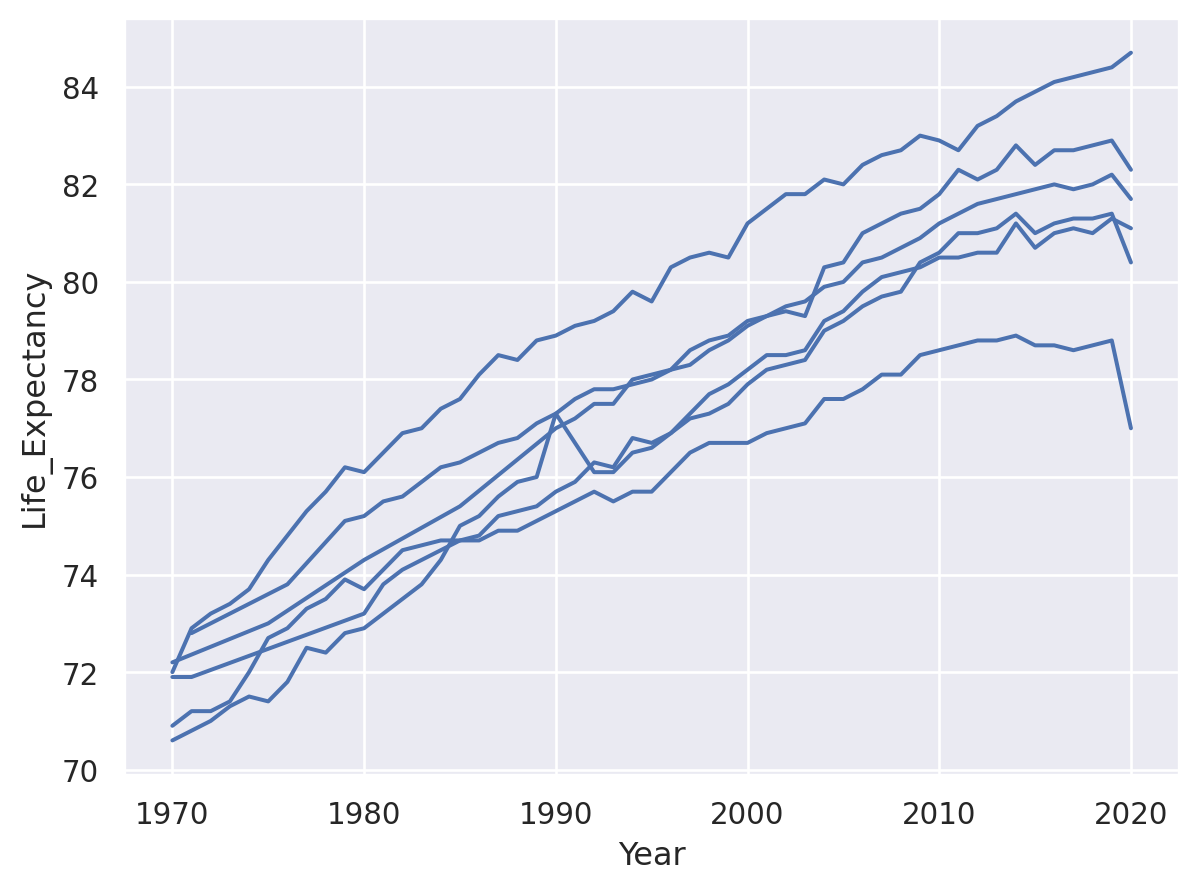

In [8]:
#initiate a plot object for healthexp dataset without color mapping
(
    so.Plot(healthexp, x="Year", y="Life_Expectancy", #dataframe, x and y axes
            group="Country"#) #grouping by Country without color mapping - see what happens when you remove the grouping
            ).add(so.Line())
)

## Transforming data before plotting
---------------------------------

### Statistical transformation

As with many seaborn functions, the objects interface supports statistical transformations. These are performed by `Stat` objects, such as `Agg`:

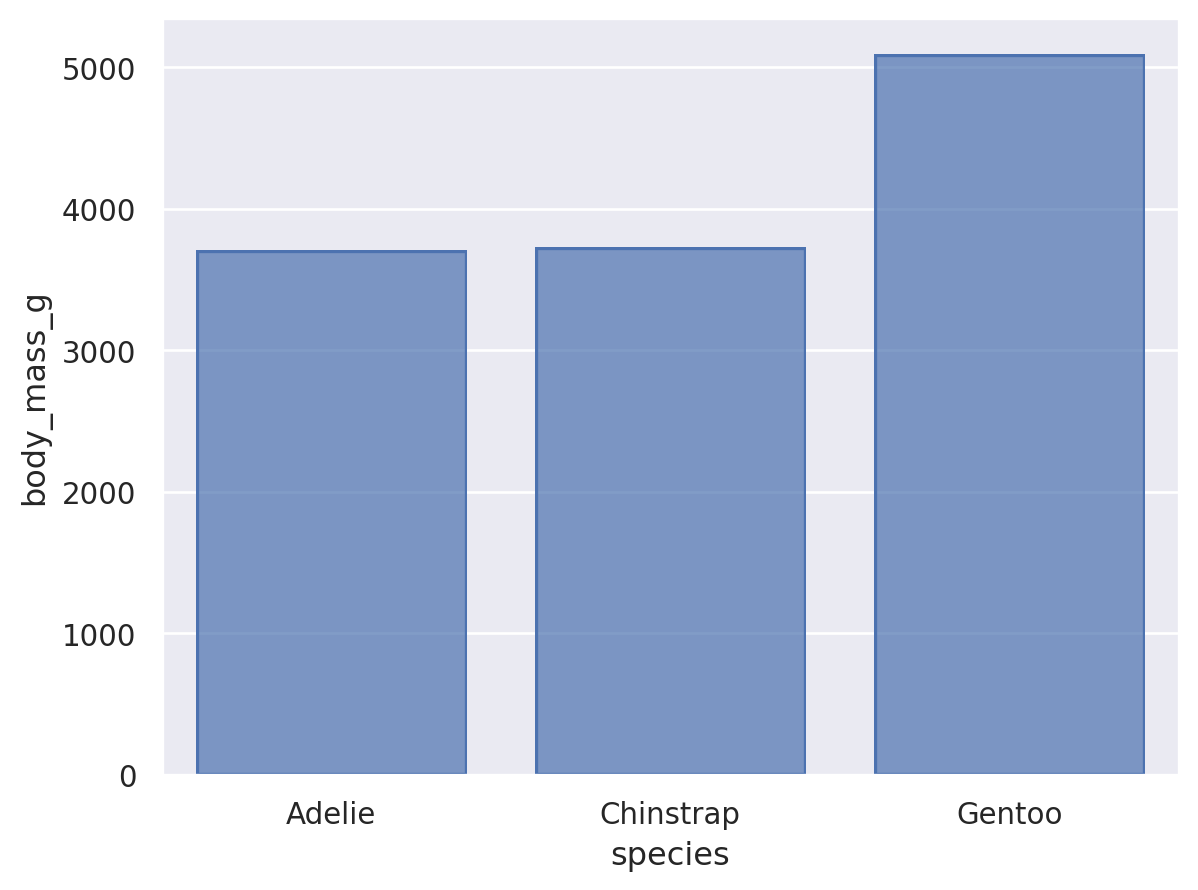

In [9]:
#Create a bar plot object showing average body mass by species
(
    so.Plot(penguins, x="species", y="body_mass_g")#dataframe, x and y axes. 
    .add(so.Bar(), so.Agg('mean')) #adding a bar layer, use aggregation to compute mean, change to other statistics as needed
)

In the function interface, statistical transformations are possible with some visual representations (e.g. `seaborn.barplot`) but not others (e.g. `seaborn.scatterplot`). The objects interface more cleanly separates representation and transformation, allowing you to compose `Mark` and `Stat` objects:

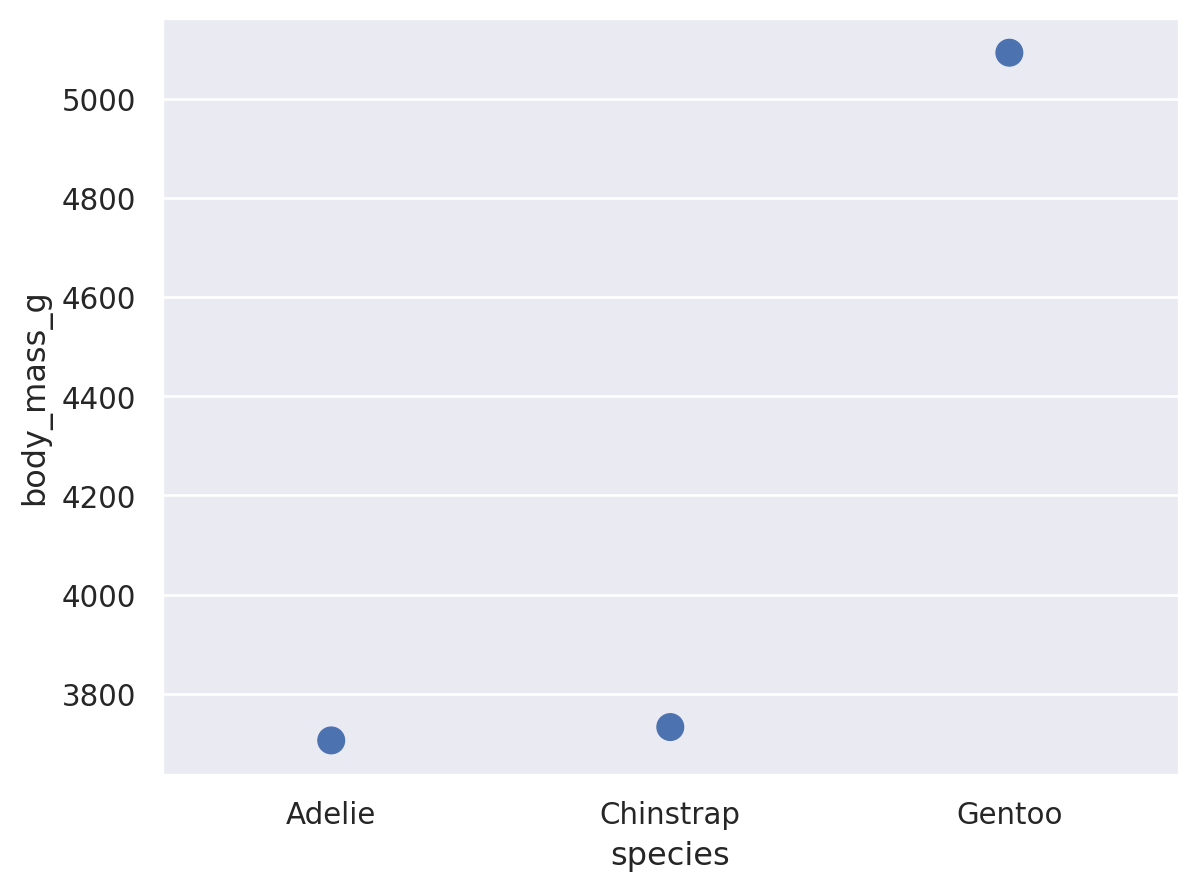

In [10]:
#same as above but with dot plot
(
    so.Plot(penguins, x="species", y="body_mass_g")
    .add(so.Dot(pointsize=10), so.Agg('mean'))
)

When forming groups by mapping properties, the `Stat` transformation is applied to each group separately:

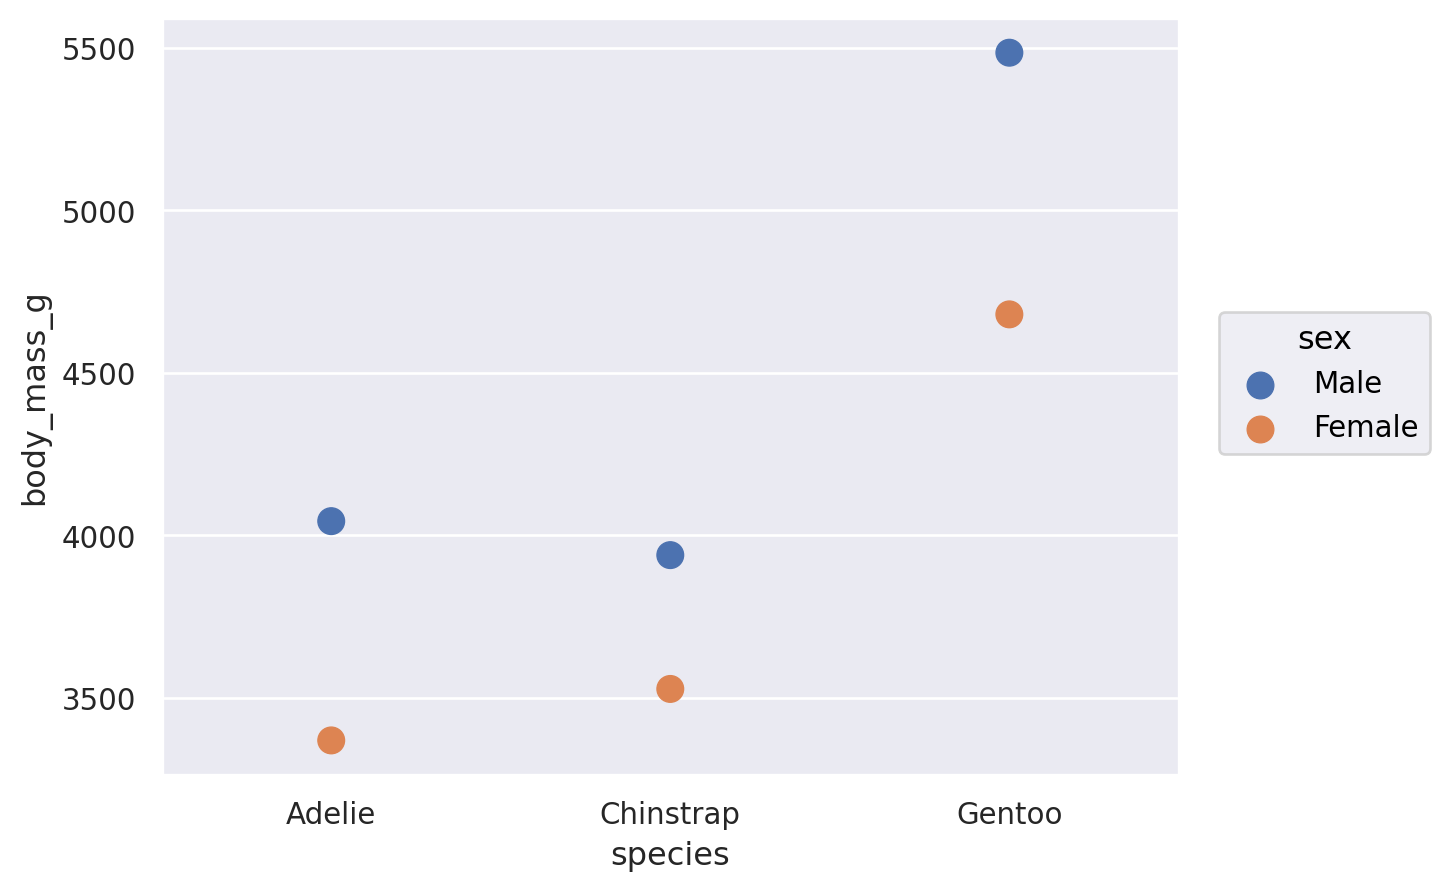

In [11]:
#same as above but with dot plot and color mapping to sex
(
    so.Plot(penguins, x="species", y="body_mass_g", 
            color="sex") #great a group by adding a color mapping to sex
    .add(so.Dot(pointsize=10), so.Agg('mean'))
)

## Resolving overplotting

Some seaborn functions also have mechanisms that automatically resolve overplotting, as when `seaborn.barplot` "dodges" bars once `hue` is assigned. The objects interface has less complex default behavior. Bars representing multiple groups will overlap by default:

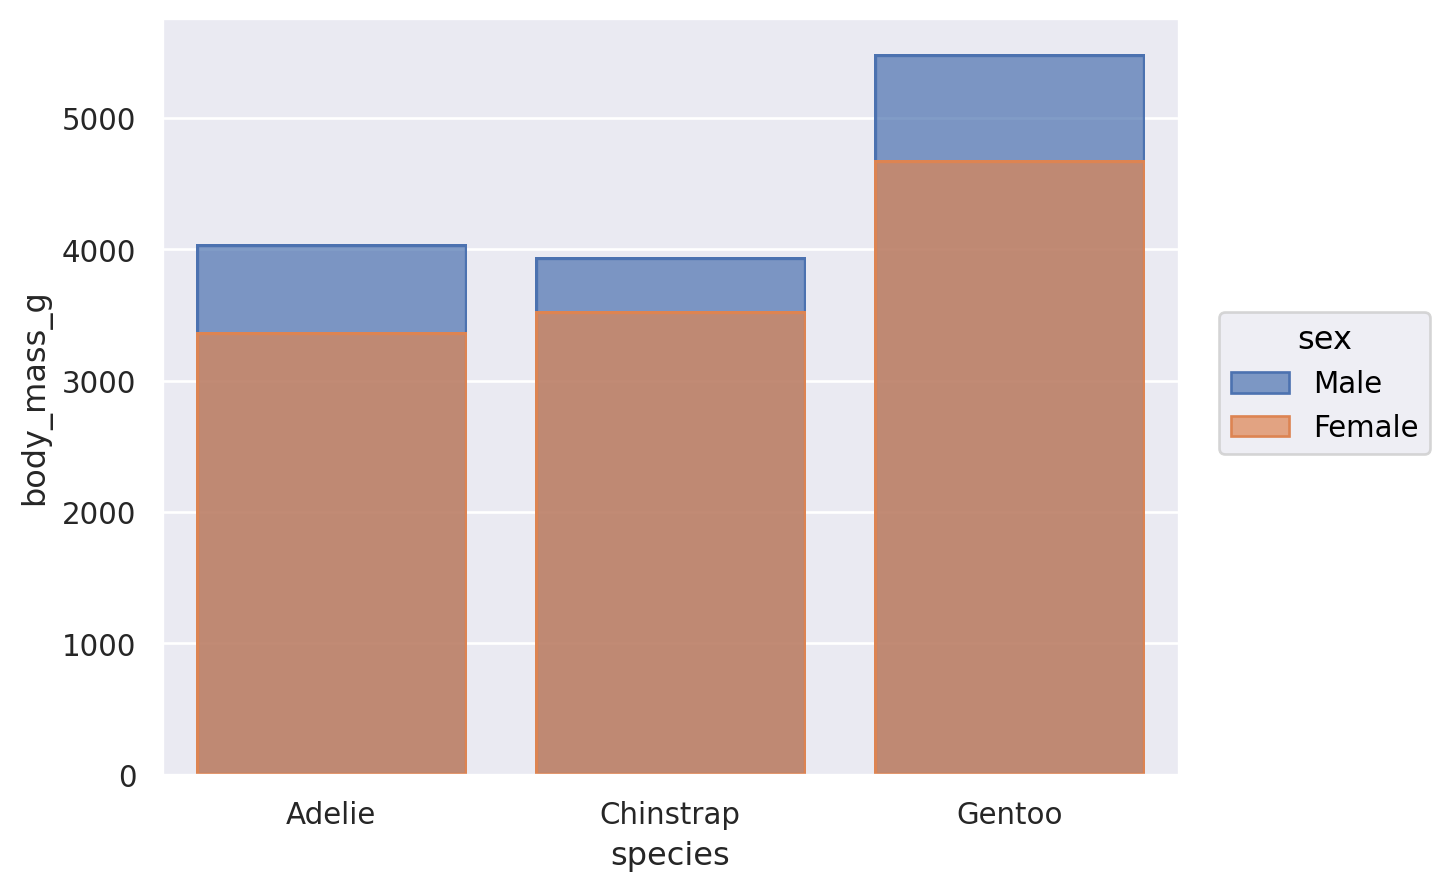

In [12]:
#bar plot with color mapping to sex
(
    so.Plot(penguins, x="species", y="body_mass_g", #dataframe, x and y axes.
            color="sex") #adding color
    .add(so.Bar(), so.Agg('mean'))# adding a bar layer, default aggregation is mean
)

It is possible to compose the `Bar` mark with the `Agg` stat and a second transformation, implemented by `Dodge`. 
**Dodge** separates the data visually by any hue/color

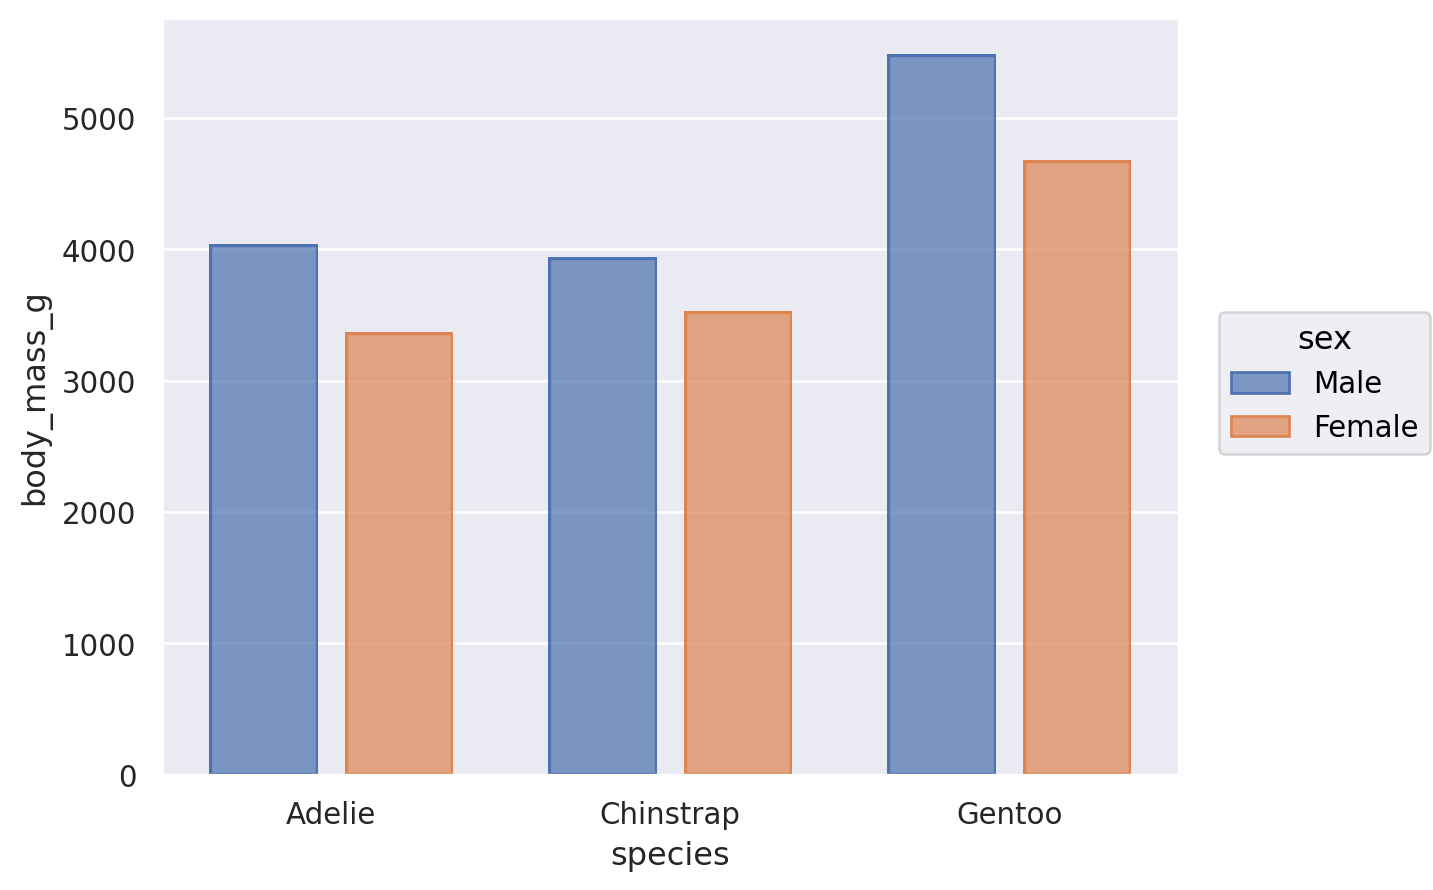

In [13]:
#recreate the above bar plot but with dodged bars
(
    so.Plot(penguins, x="species", y="body_mass_g", 
            color="sex") #adding color
    .add(so.Bar(), so.Agg('mean'), so.Dodge(gap=0.2)) #dodging bars by color variable, separate bars for each sex
)

The `Dodge` class is an example of a `Move` transformation, which is like a `Stat` but only adjusts `x` and `y` coordinates. The `Move` classes can be applied with any mark, and it's not necessary to use a `Stat` first:

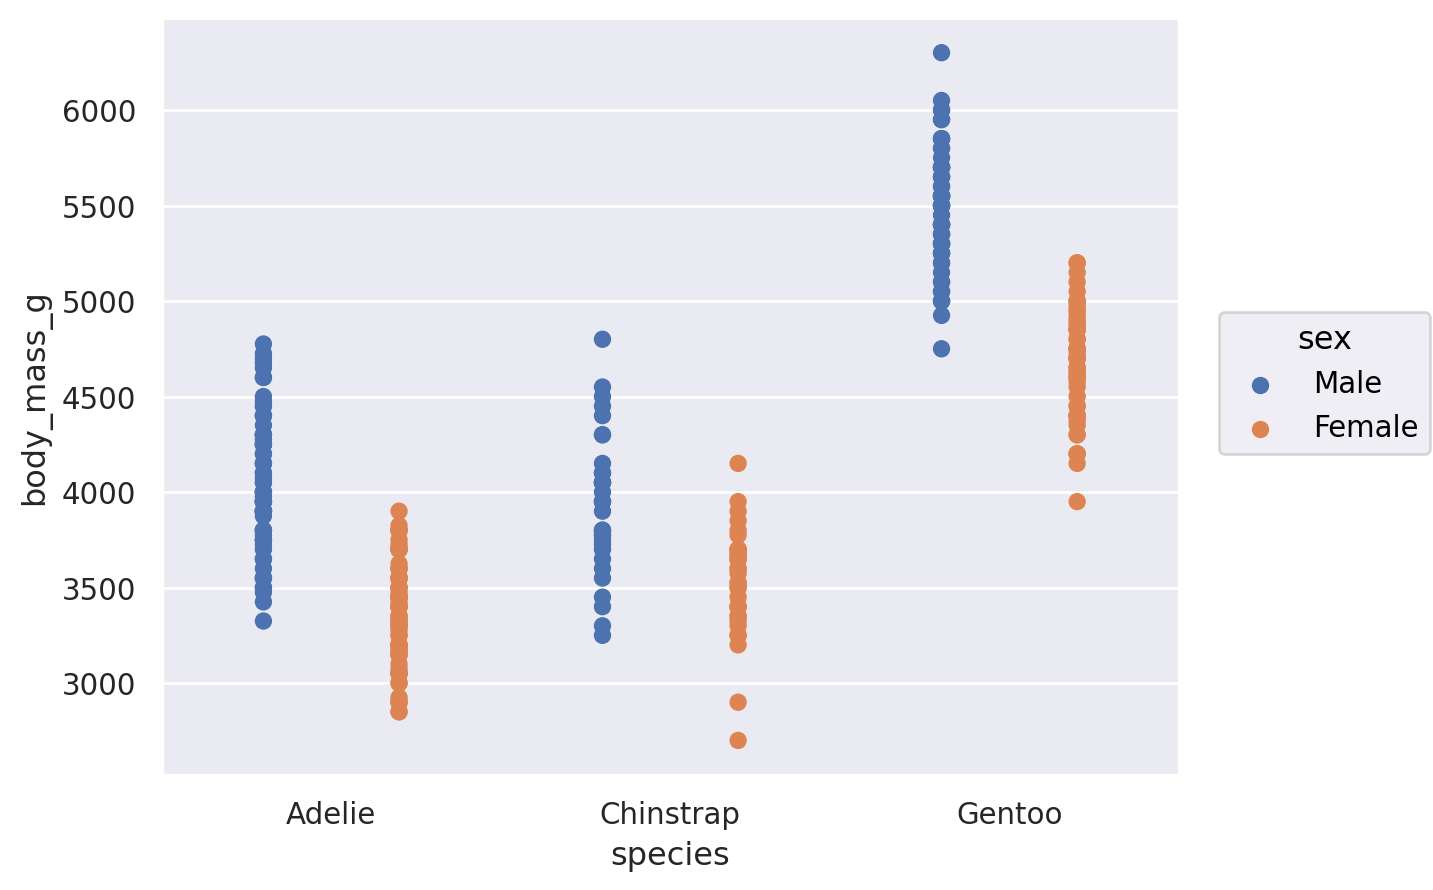

In [14]:
#create a dot plot with dodged points
(
    so.Plot(penguins, x="species", y="body_mass_g", #dataframe, x and y axes.
            color="sex") #adding color
    .add(so.Dot(), so.Dodge()) # add the dot layer with dodged points by color variable
)

It's also possible to apply multiple `Move` operations in sequence:

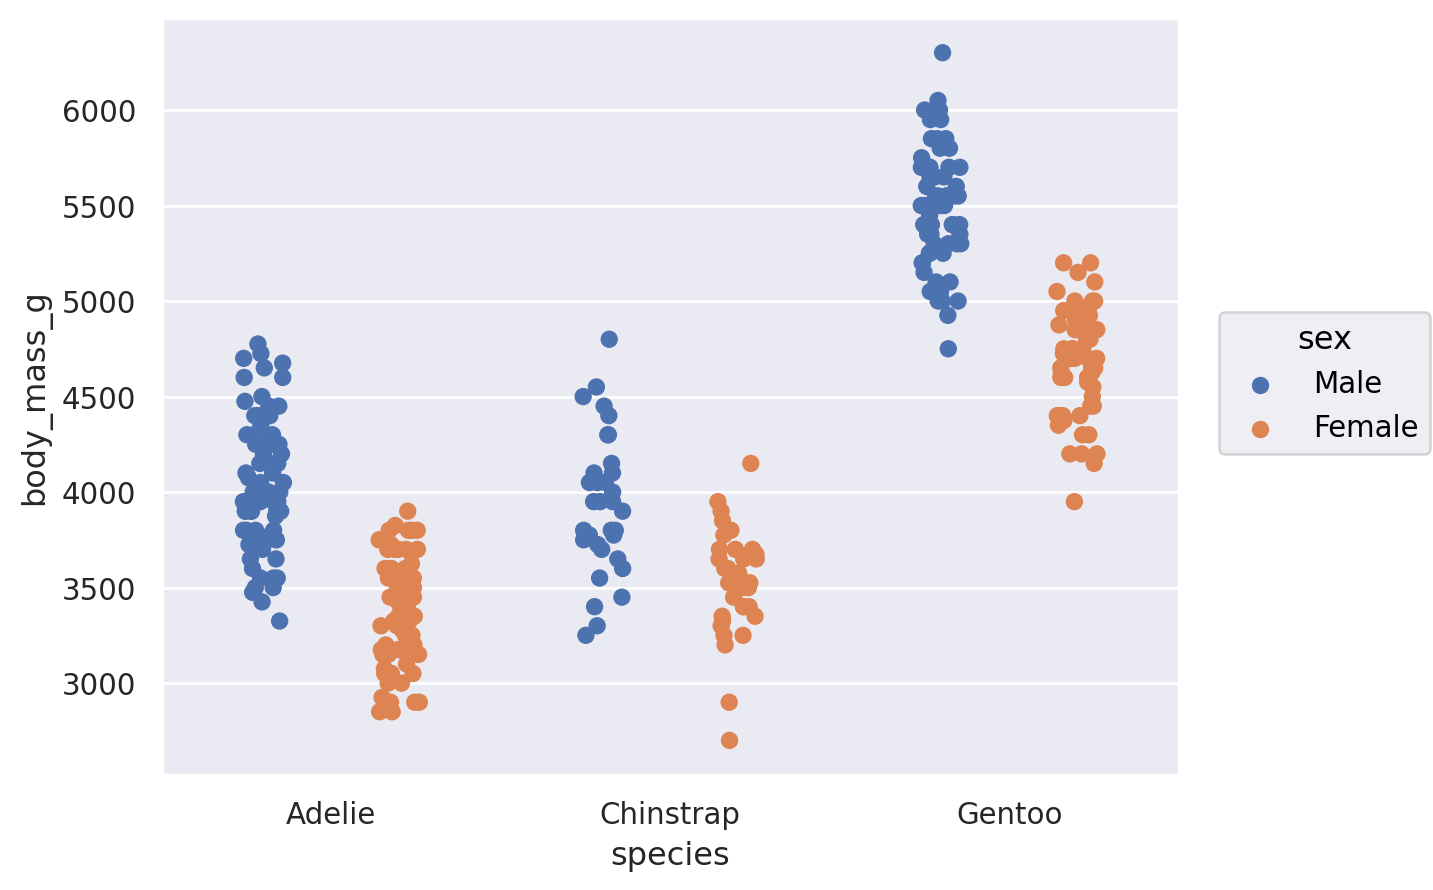

In [15]:
#create a dot plot with dodged and jittered points
(
    so.Plot(penguins, x="species", y="body_mass_g", #dataframe, x and y axes.
            color="sex") #adding color
    .add(so.Dot(), so.Dodge(), so.Jitter(.3)) # add the dot layer with dodged and jittered points by color variable. Jitter is a random noise added to the points to reduce overplotting
)

## Creating variables through transformation

The `Agg` stat requires both `x` and `y` to already be defined, but variables can also be *created* through statistical transformation. For example, the `Hist` stat requires only one of `x` *or* `y` to be defined, and it will create the other by counting observations:

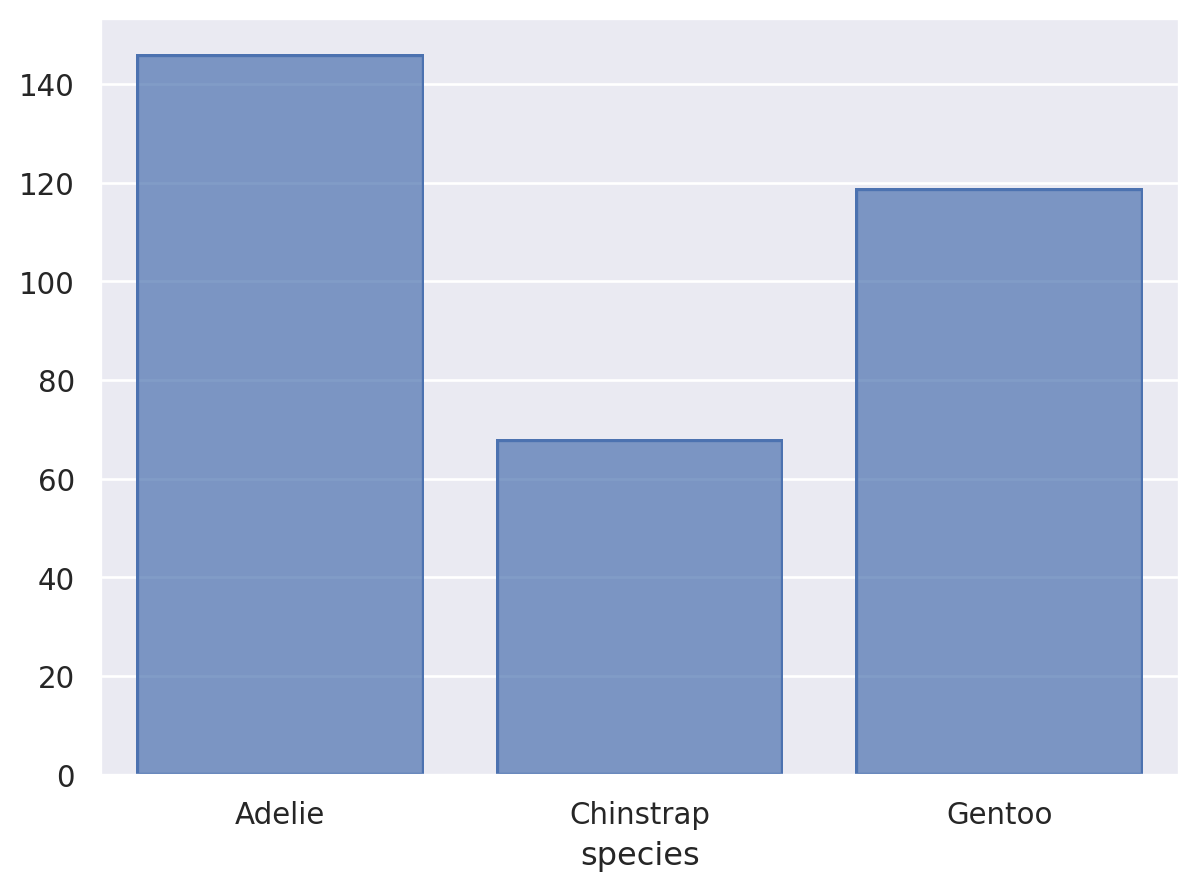

In [16]:
#create a bar plot showing counts of each species
(
    so.Plot(penguins, x="species") #dataframe, x axis only for counts
    .add(so.Bar(), so.Hist()) # adding a bar layer with histogram aggregation to show counts
)

The `Hist` stat will also create new `x` values (by binning) when given numeric data:

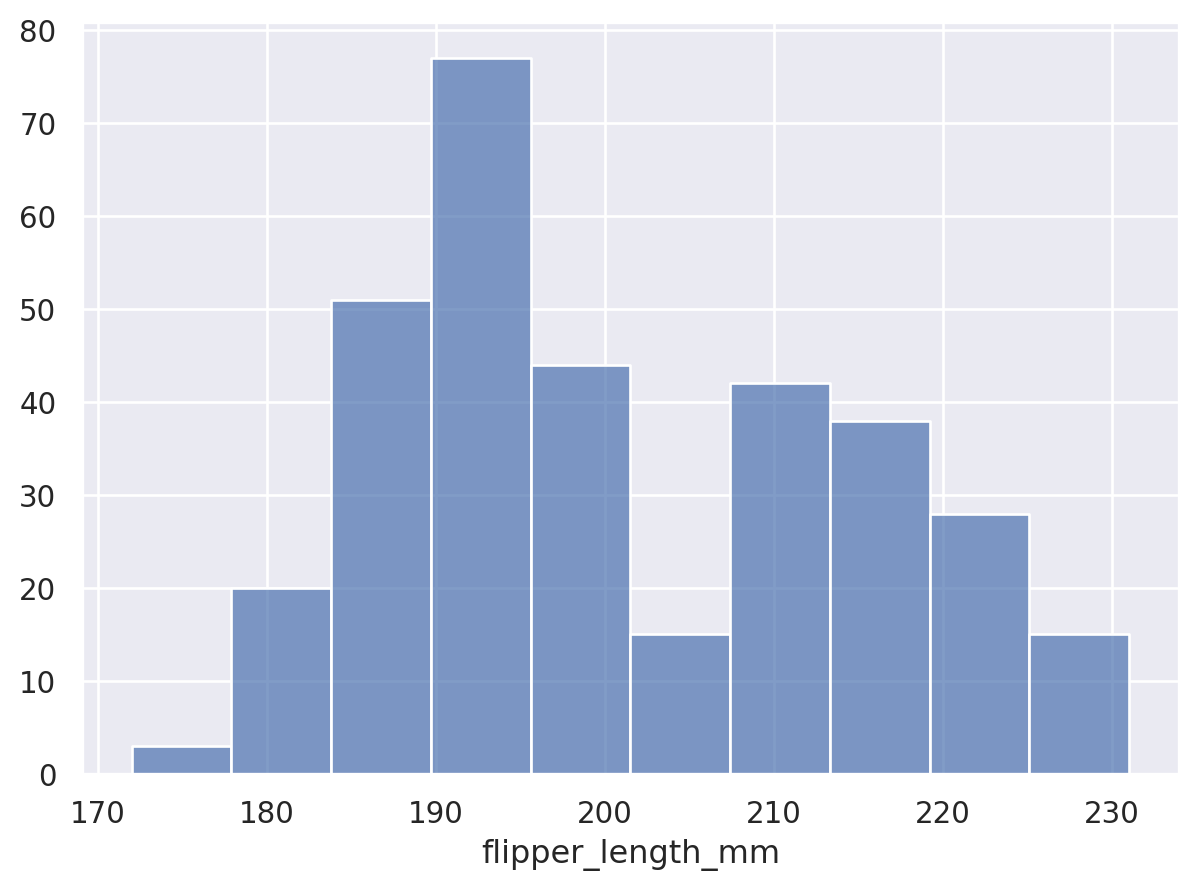

In [17]:
(
    so.Plot(penguins, x="flipper_length_mm") #dataframe, x axis only
    .add(so.Bars(), so.Hist()) # adding bar layer with histogram aggregation, notice Bars is plural here, see what happens when you use Bar instead
)

Notice how we used `Bars`, rather than `Bar` for the plot with the continuous `x` axis. These two marks are related, but `Bars` has different defaults and works better for continuous histograms. It also produces a different, more efficient matplotlib artist. You will find the pattern of singular/plural marks elsewhere. **The plural version is typically optimized for cases with larger numbers of marks**.

Some transforms accept both `x` and `y`, but add *interval* data for each coordinate. This is particularly relevant for plotting error bars after aggregating:

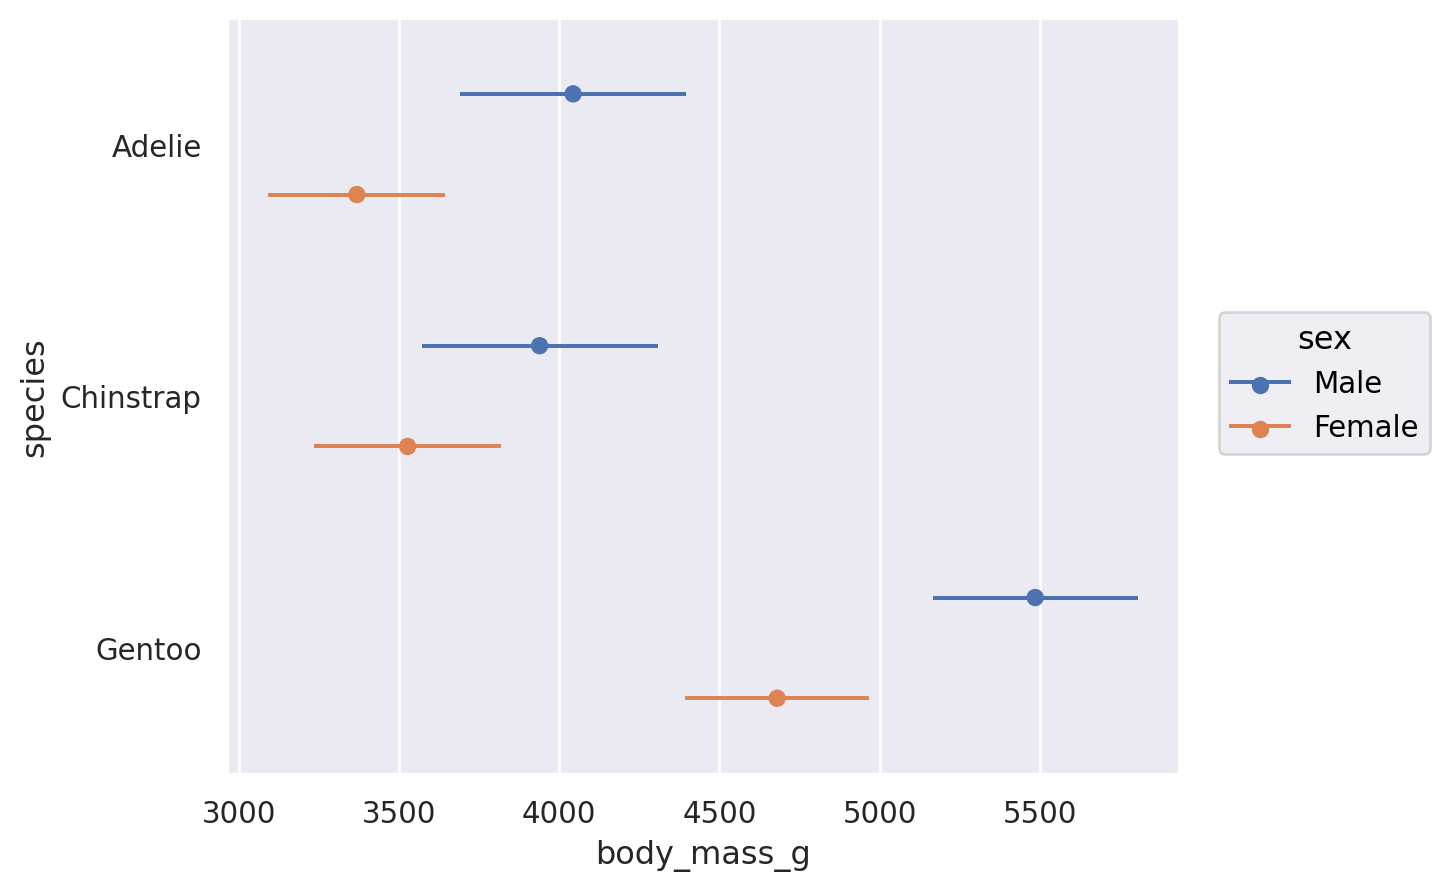

In [18]:
#create a horizontal bar plot with dodged range and dot layers, we can keep adding layers with .add()
(
    so.Plot(penguins, x="body_mass_g", y="species",  #setting dataframe, x and y axes
            color="sex") #mapping color to sex
    .add(so.Range(), so.Est(errorbar="sd"), so.Dodge()) #adding a range layer with standard deviation error bars, dodged by color variable
    .add(so.Dot(), so.Agg(), so.Dodge()) #adding a dot layer with aggregated points, dodged by color variable, see what happen you # the .add
)

## Orienting marks and transforms

When aggregating, dodging, and drawing a bar, the `x` and `y` variables are treated differently. Each operation has the concept of an *orientation*. The `Plot` tries to determine the orientation automatically based on the data types of the variables. For instance, if we flip the assignment of `species` and `body_mass_g`, we'll get the same plot, but oriented horizontally:

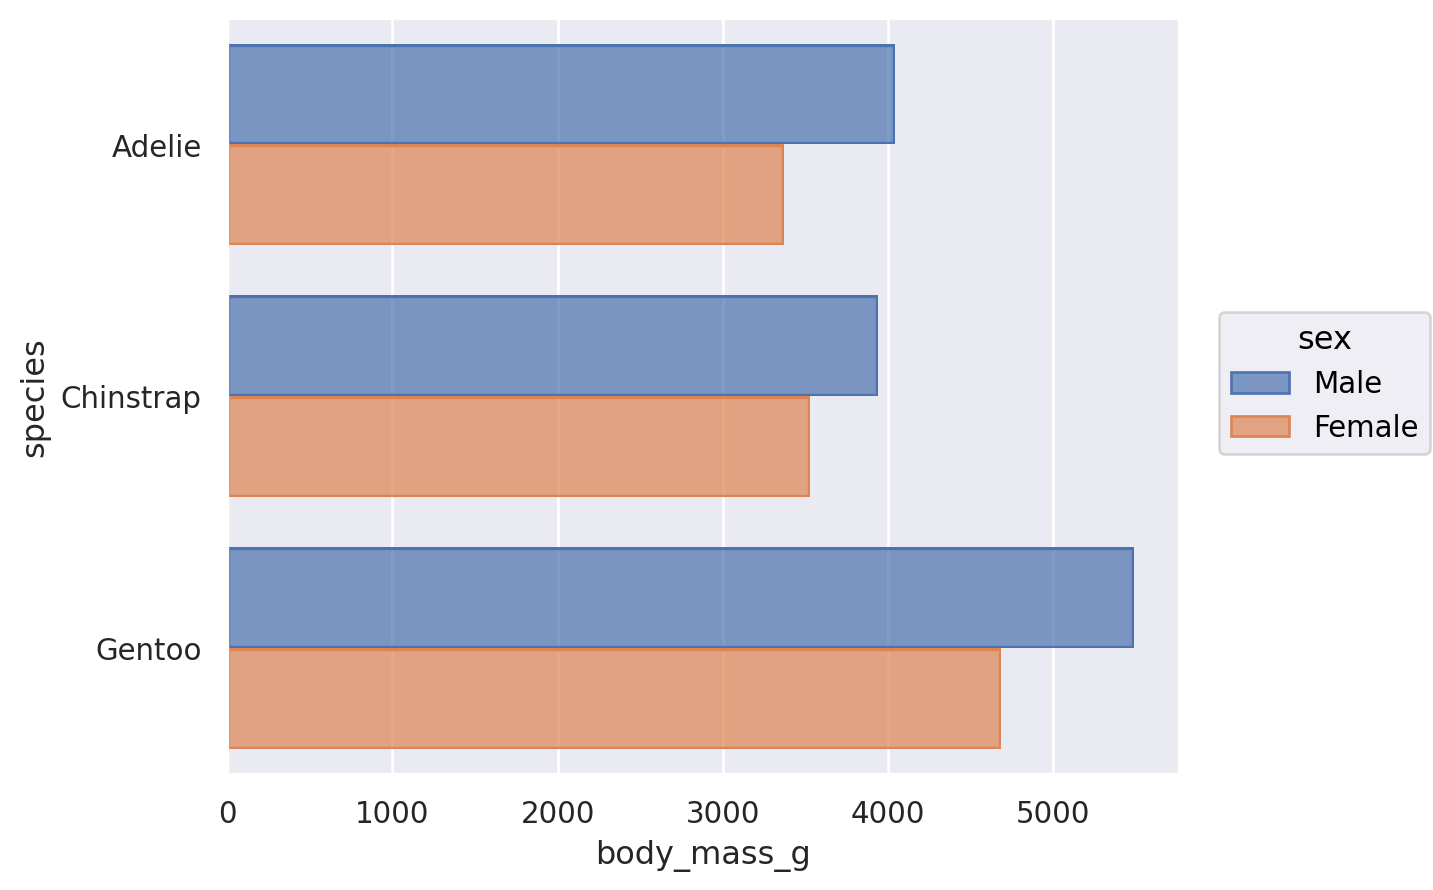

In [19]:
#Instantiate a bar plot with dodged bars
(
    so.Plot(penguins, x="body_mass_g", y="species", #setting dataframe, x and y axes, note that we swapped x and y compared to previous plot
            color="sex")#mapping color to sex
    .add(so.Bar(), so.Agg('mean'), so.Dodge()) #adding a bar layer, aggregate by mean, split the bars by color variable using Dodge
)

Sometimes, the correct orientation is ambiguous, as when both the `x` and `y` variables are numeric. In these cases, you can be explicit by passing the `orient` parameter to `Plot.add`:

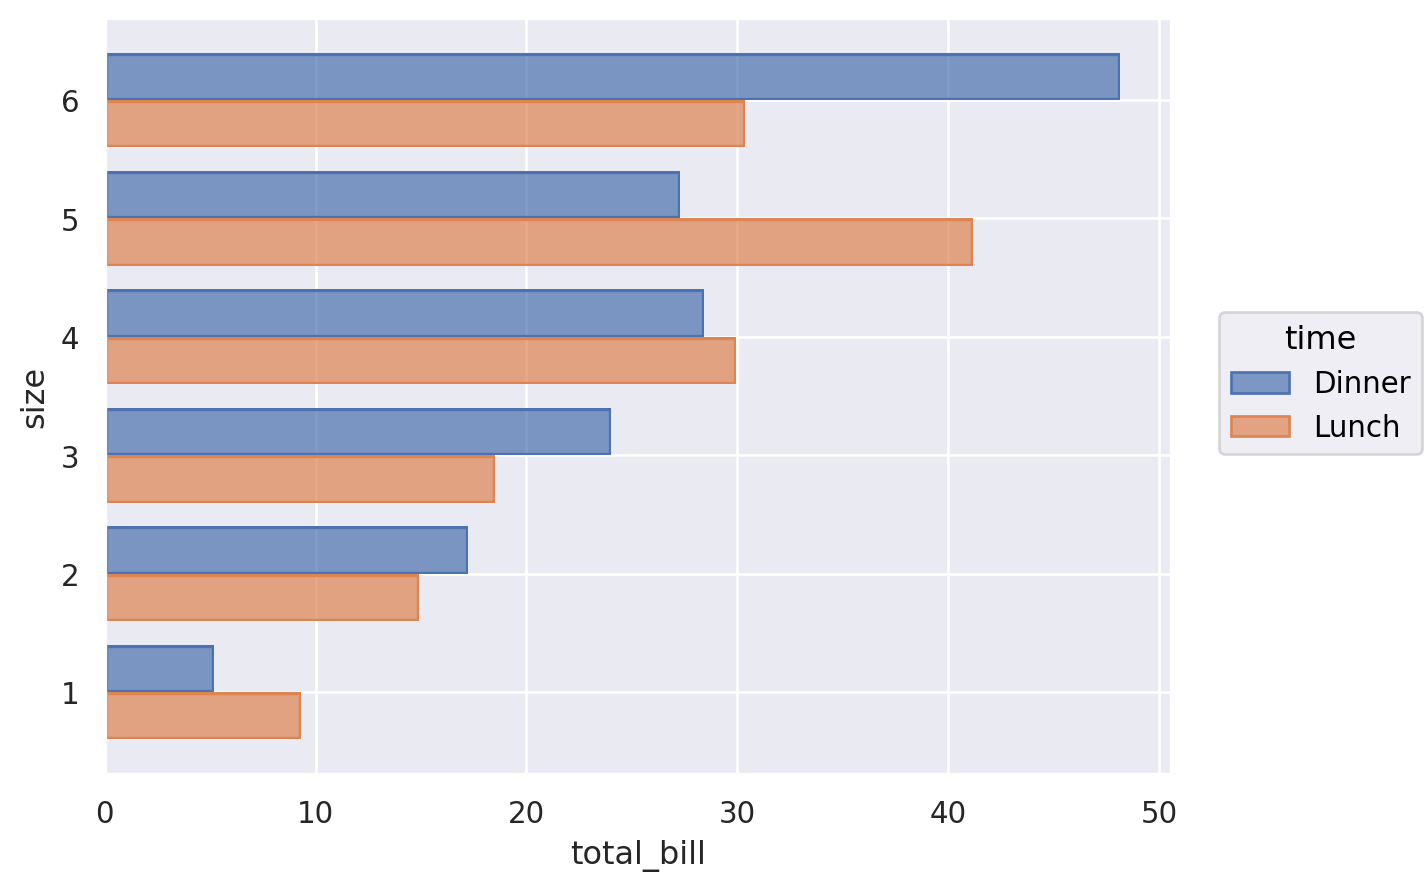

In [20]:
#instantiate a bar plot with dodged bars for tips dataset
(
    so.Plot(tips, x="total_bill", y="size", #dataframe, x and y axes
            color="time")#mapping color to time
    .add(so.Bar(), so.Agg('mean'), so.Dodge(), orient="y") #adding a bar layer, aggregation is mean, dodged/split by time, orient bars horizontally
)

## Building and displaying the plot
--------------------------------

Most examples this far have produced a single subplot with just one kind of mark on it. But `Plot` does not limit you to this.

### Adding multiple layers


More complex single-subplot graphics can be created by calling `Plot.add` repeatedly. Each time it is called, it defines a *layer* in the plot. For example, we may want to add a scatterplot (now using `Dots`) and then a regression fit:

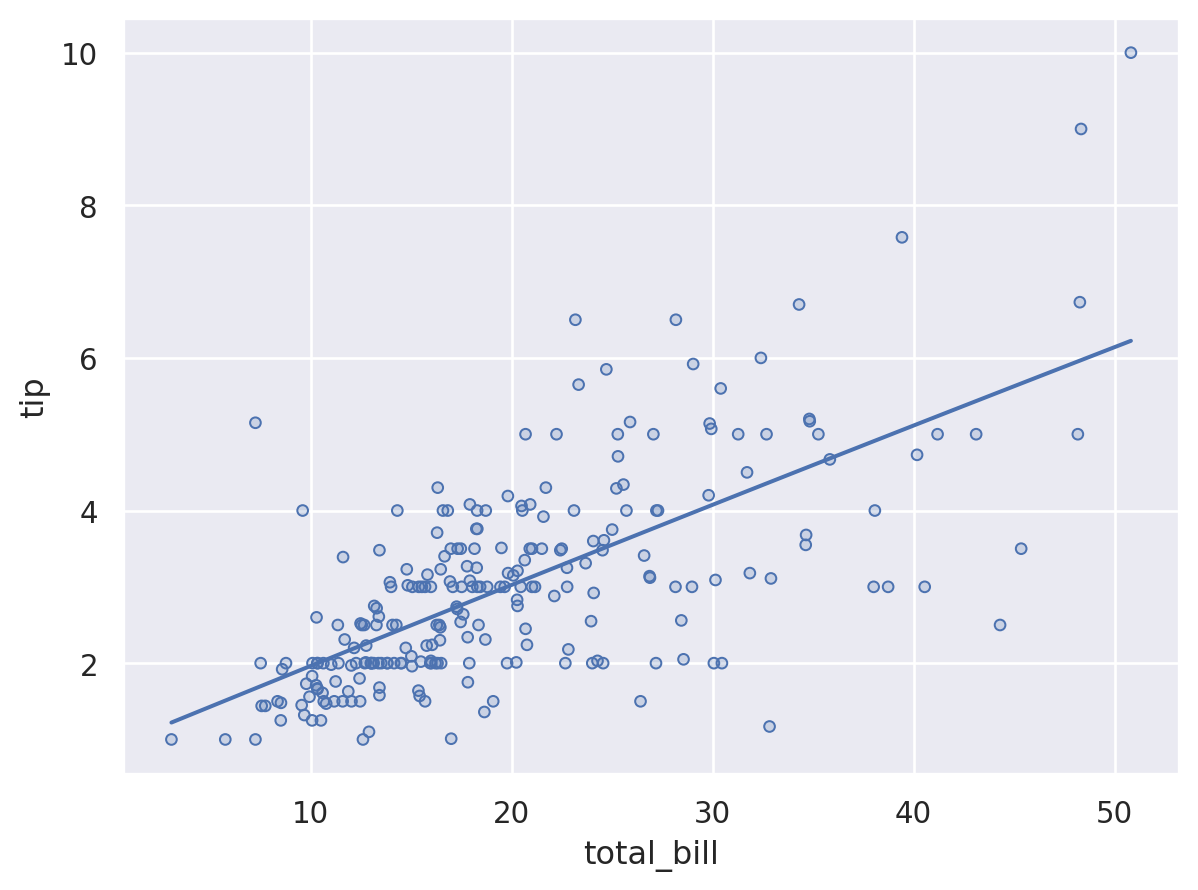

In [21]:
#create a scatter plot with a polynomial fit line
(
    so.Plot(tips, x="total_bill", y="tip") #dataframe, x and y axes
    .add(so.Dots()) #adding a dot layer
    .add(so.Line(), so.PolyFit()) #adding a line layer with polynomial fit
)

Variable mappings that are defined in the `Plot` constructor will be used for all layers:

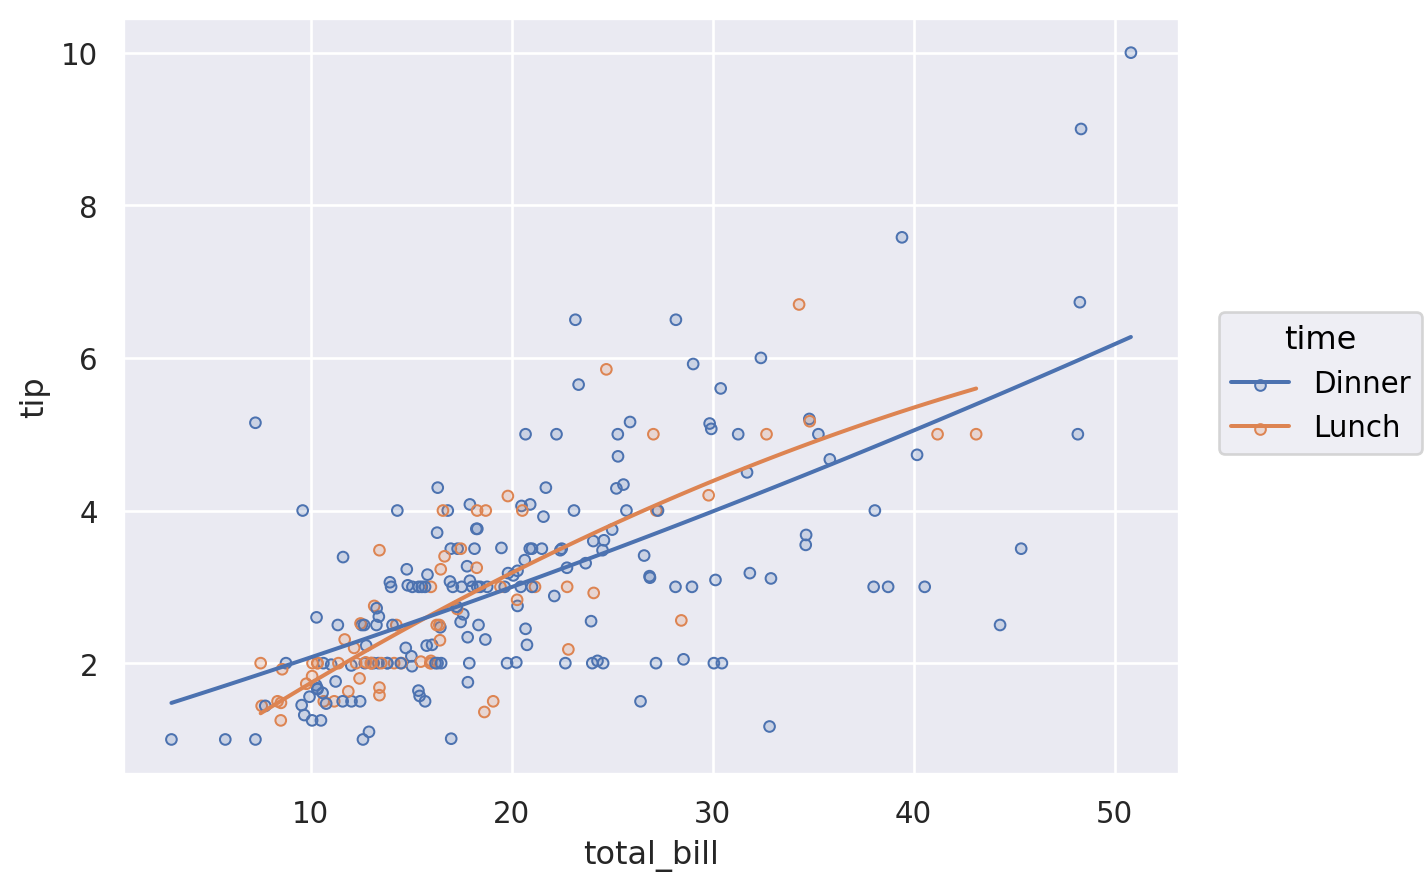

In [22]:
#create a scatter plot with a polynomial fit line, color mapped to time
(
    so.Plot(tips, x="total_bill", y="tip", #dataframe, x and y axes
            color="time") #mapping color to time
    .add(so.Dots()) #adding a dot layer
    .add(so.Line(), so.PolyFit()) #adding a line layer with polynomial fit
) #notice how the plot now splits the regression lines by time of day

## Layer-specific mappings

You can also define a mapping such that it is used only in a specific layer. This is accomplished by defining the mapping within the call to `Plot.add` for the relevant layer:

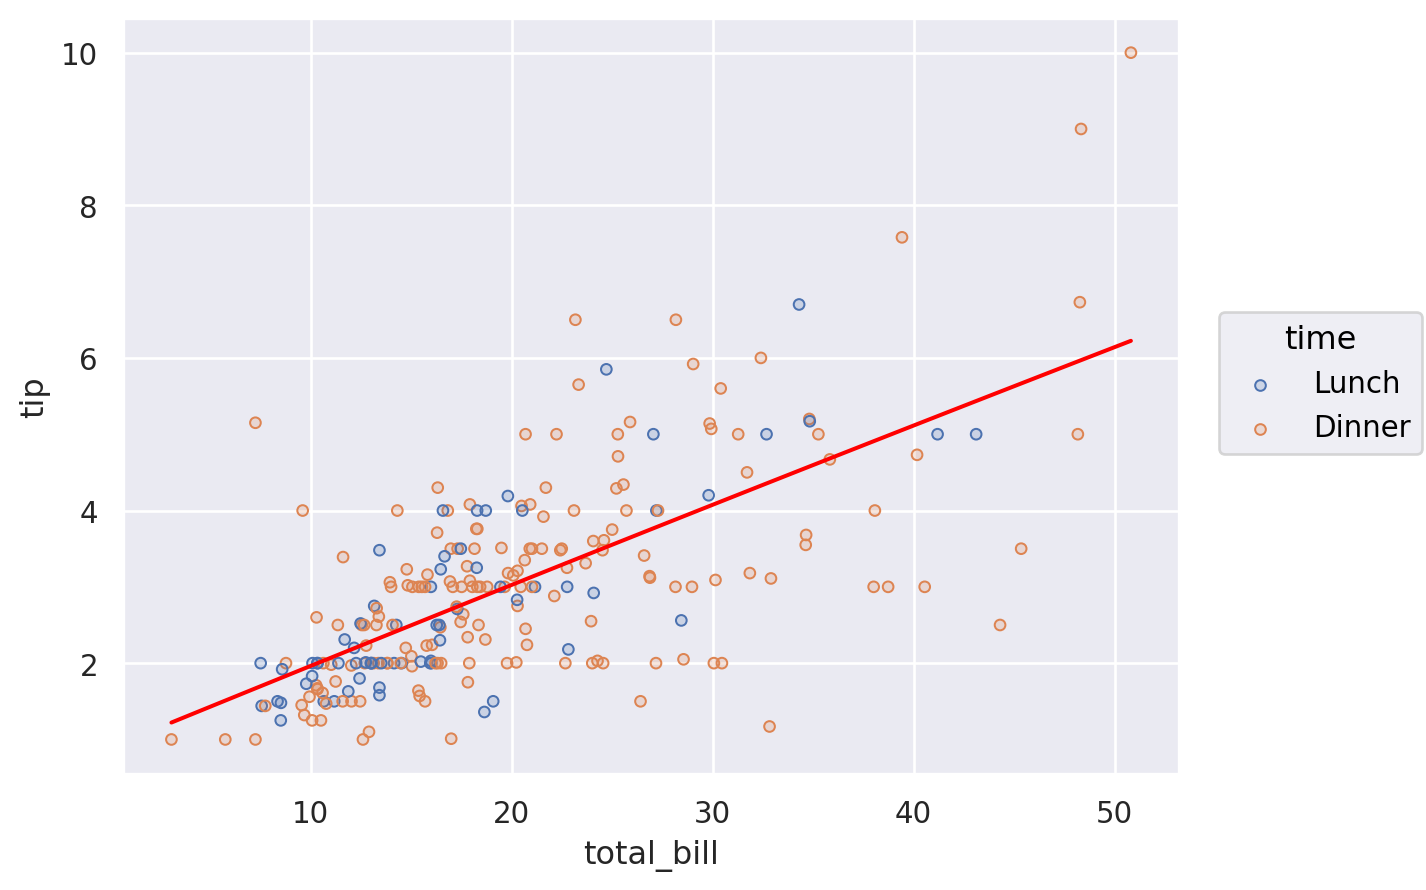

In [23]:
#create a scatter plot with a polynomial fit line, color mapped to time and darker line
(
    so.Plot(tips, x="total_bill", y="tip") #dataframe, x and y axes
    .add(so.Dots(), color="time")#mapping color to time for the dots
    .add(so.Line(color="red"), so.PolyFit()) #adding a line layer with polynomial fit and red line color
)

Alternatively, define the layer for the entire plot, but *remove* it from a specific layer by setting the variable to `None`:

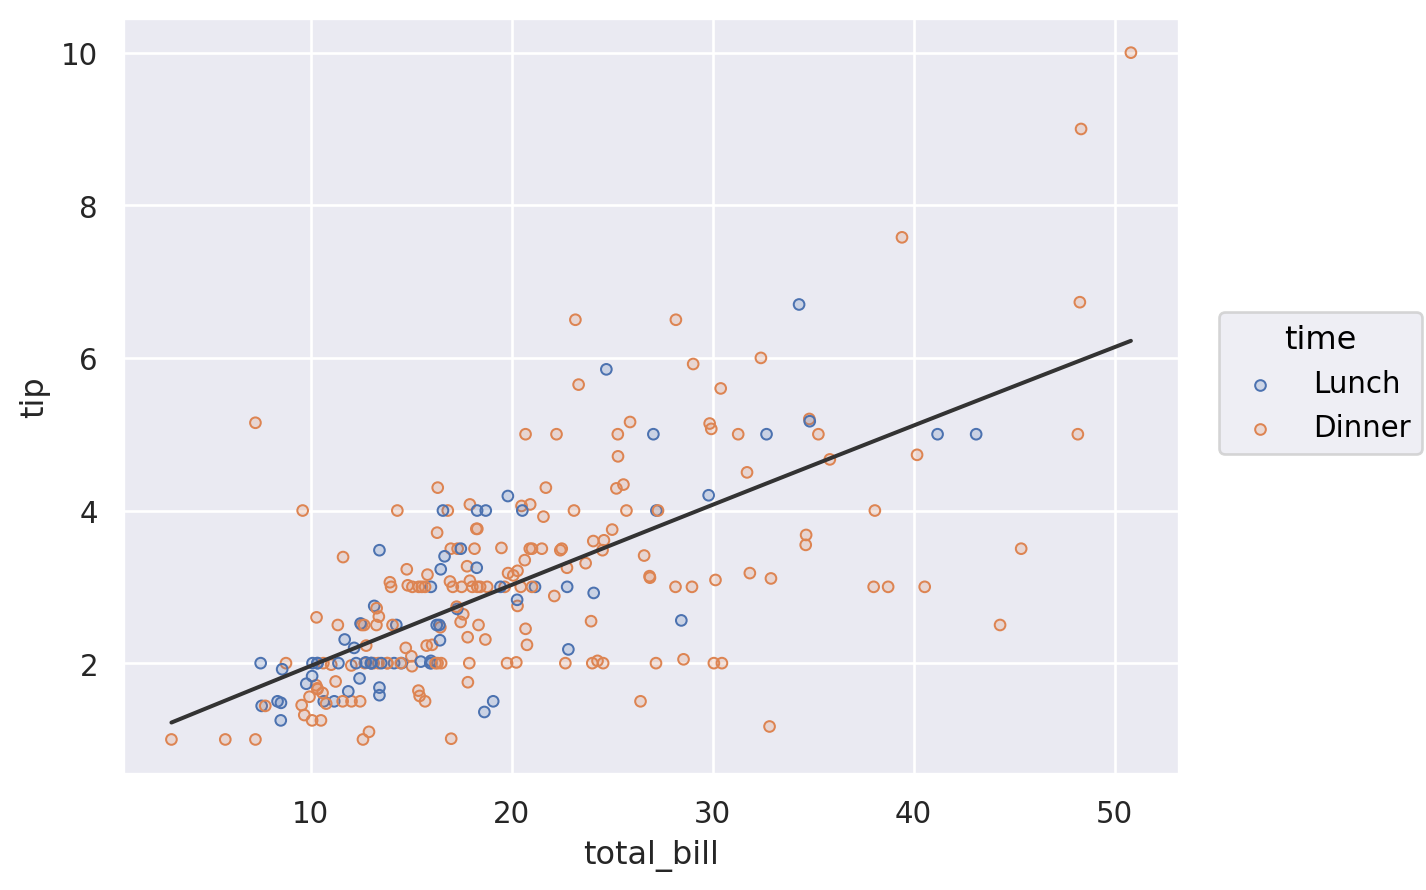

In [ ]:
#instantiate a scatter plot with polynomial fit line, color mapped to time but line in blue
(
    so.Plot(tips, x="total_bill", y="tip", #dataframe, x and y axes
            color="time")#mapping color to time
    .add(so.Dots())#adding a dot layer
    .add(so.Line(color="blue"), so.PolyFit(), color=None)# line in blue regardless of time mapping
)

To recap, there are three ways to specify the value of a mark property: (1) by mapping a variable in all layers, (2) by mapping a variable in a specific layer, and (3) by setting the property directly:

## Faceting and pairing subplots


As with seaborn's figure-level functions (`seaborn.displot`, `seaborn.catplot`, etc.), the `Plot` interface can also produce figures with multiple "facets", or subplots containing subsets of data. This is accomplished with the `Plot.facet` method:

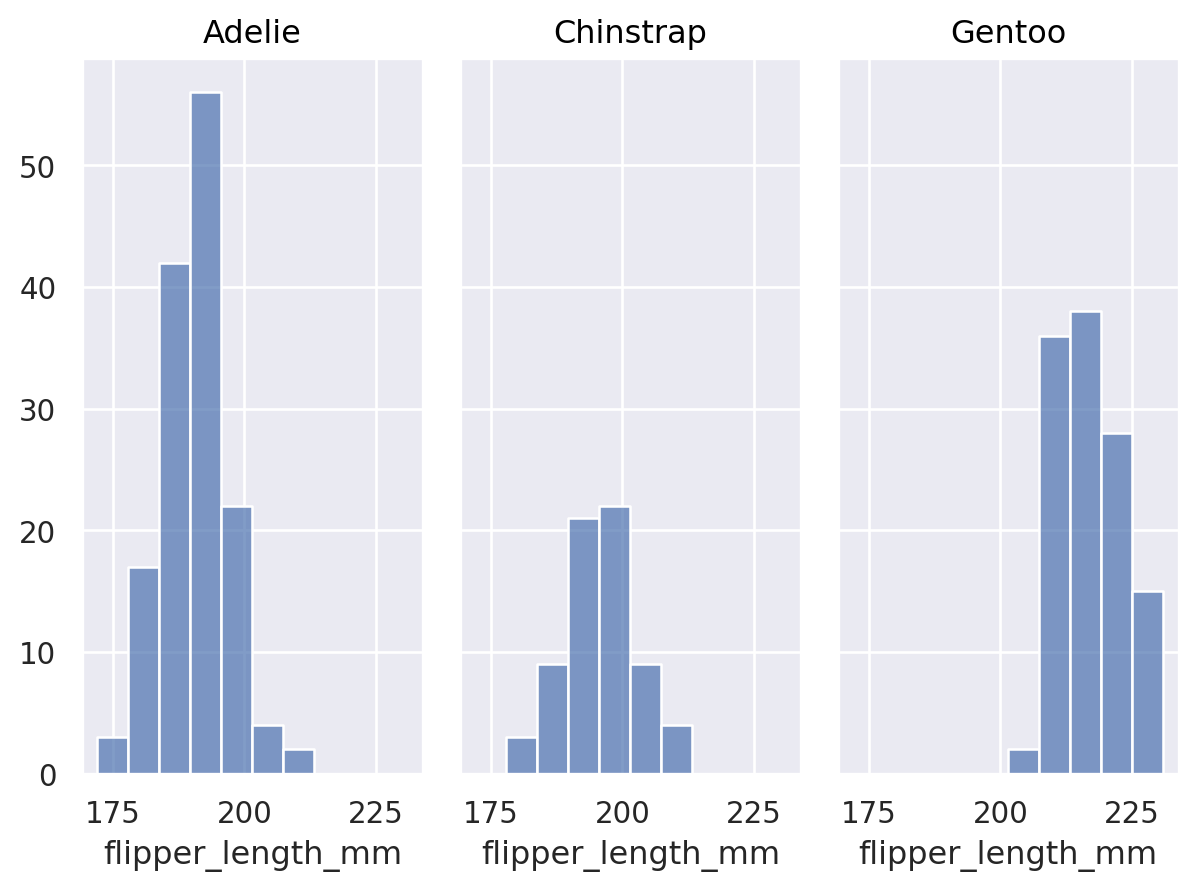

In [25]:
#instantiate a faceted histogram of flipper lengths by species
(
    so.Plot(penguins, x="flipper_length_mm") #dataframe, x axis
    .facet("species") #faceting by species
    .add(so.Bars(), so.Hist()) #
)

Call `Plot.facet` with the variables that should be used to define the columns and/or rows of the plot:

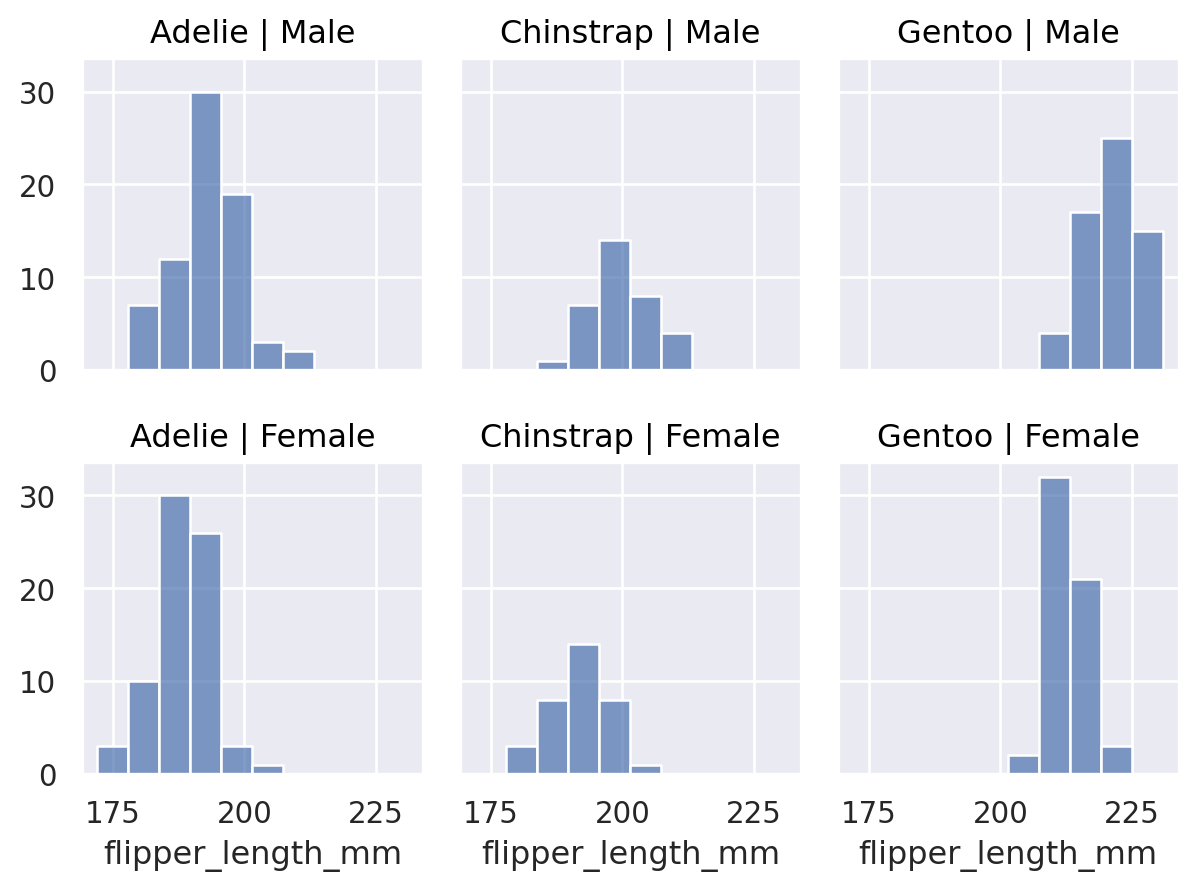

In [26]:
#instantiate a faceted histogram of flipper lengths by species
(
    so.Plot(penguins, x="flipper_length_mm")# dataframe, x axis
    .facet(col="species", row="sex")#faceting by species and sex
    .add(so.Bars(), so.Hist())#add ing bar layer with histogram aggregation
)

You can facet using a variable with a larger number of levels by "wrapping" across the other dimension:

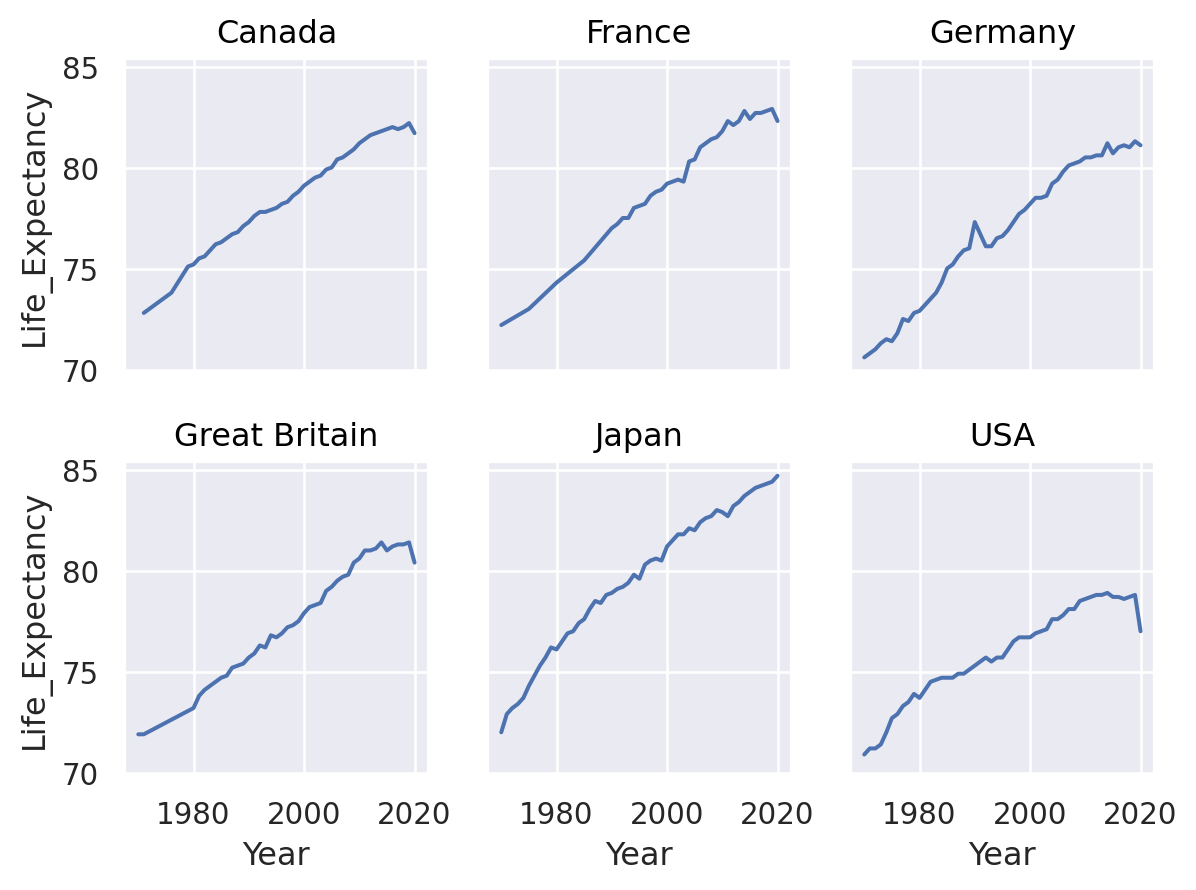

In [27]:
#instantiate a faceted line plot of life expectancy over time by country
(
    so.Plot(healthexp, x="Year", y="Life_Expectancy") #dataframe, x and y axes
    .facet(col="Country", wrap=3) #faceting by country with 3 columns
    .add(so.Line()) #add a line layer
)

All layers will be faceted unless you explicitly exclude them, which can be useful for providing additional context on each subplot:

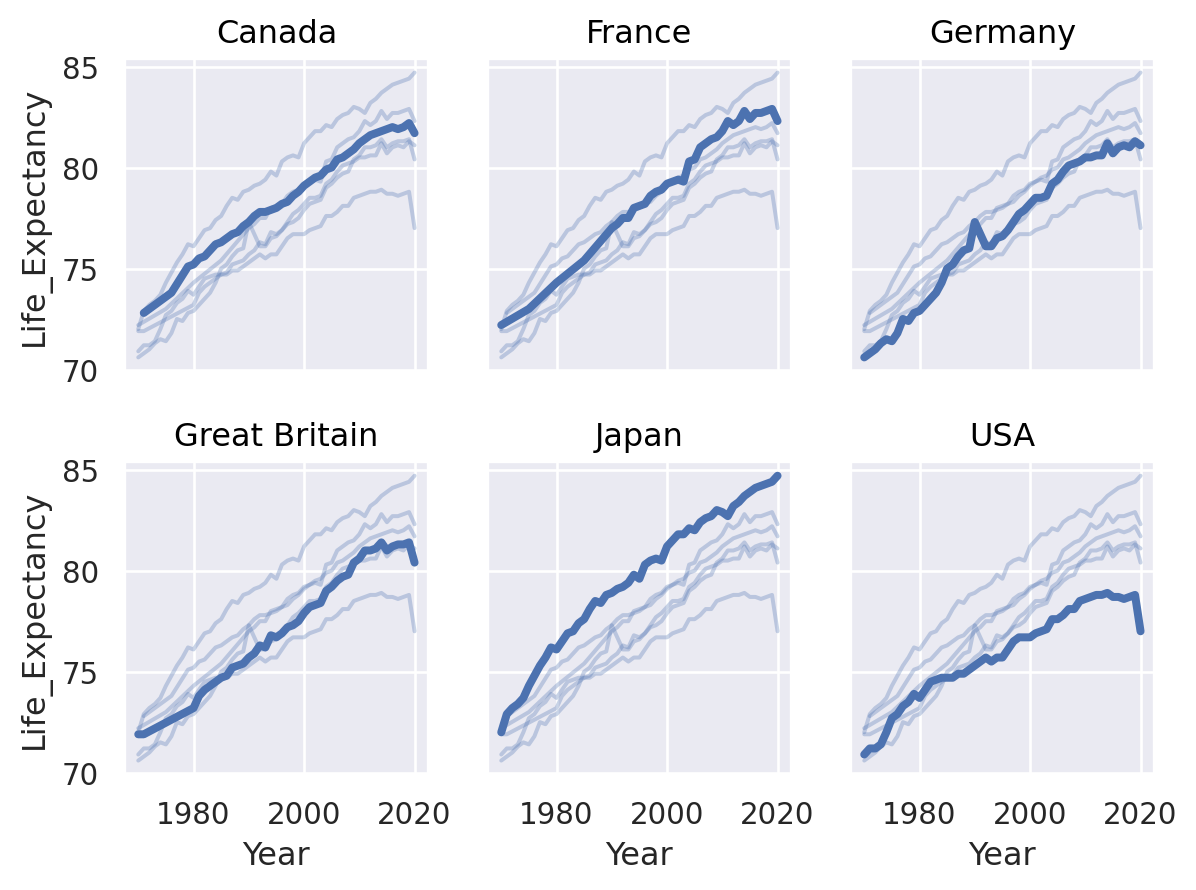

In [ ]:
#instantiate a faceted line plot of life expectancy over time by country with faded lines for each country and bold overall line
(
    so.Plot(healthexp, x="Year", y="Life_Expectancy") #dataframe, x and y axes
    .facet("Country", wrap=3) #faceting by country with 3 columns
    .add(so.Line(alpha=.3), group="Country", col=None) #faded lines for each country, see what happens when you remove group and col arguments
    .add(so.Line(linewidth=3)) #bold overall line
)

An alternate way to produce subplots is `Plot.pair`. Like `seaborn.PairGrid`, this draws all of the data on each subplot, using different variables for the x and/or y coordinates:

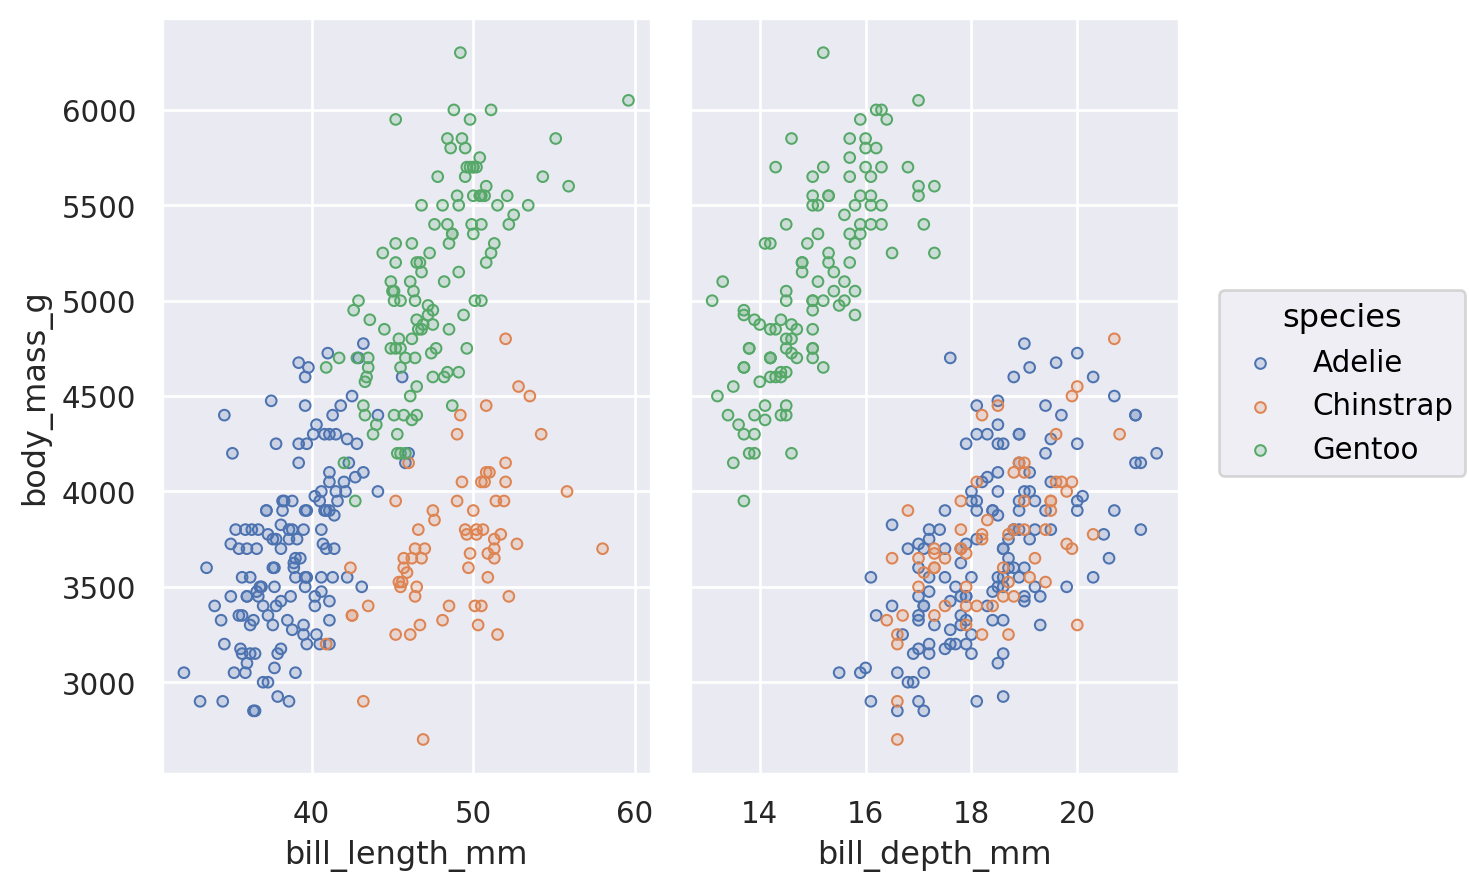

In [29]:
#scatter plot of body mass vs bill dimensions, color mapped to species
(
    so.Plot(penguins, y="body_mass_g", color="species") #dataframe, y axis and color mapping
    .pair(x=["bill_length_mm", "bill_depth_mm"]) #pairing x axis with bill length and depth
    .add(so.Dots()) #adding dot layer
)

You can combine faceting and pairing so long as the operations add subplots on opposite dimensions:

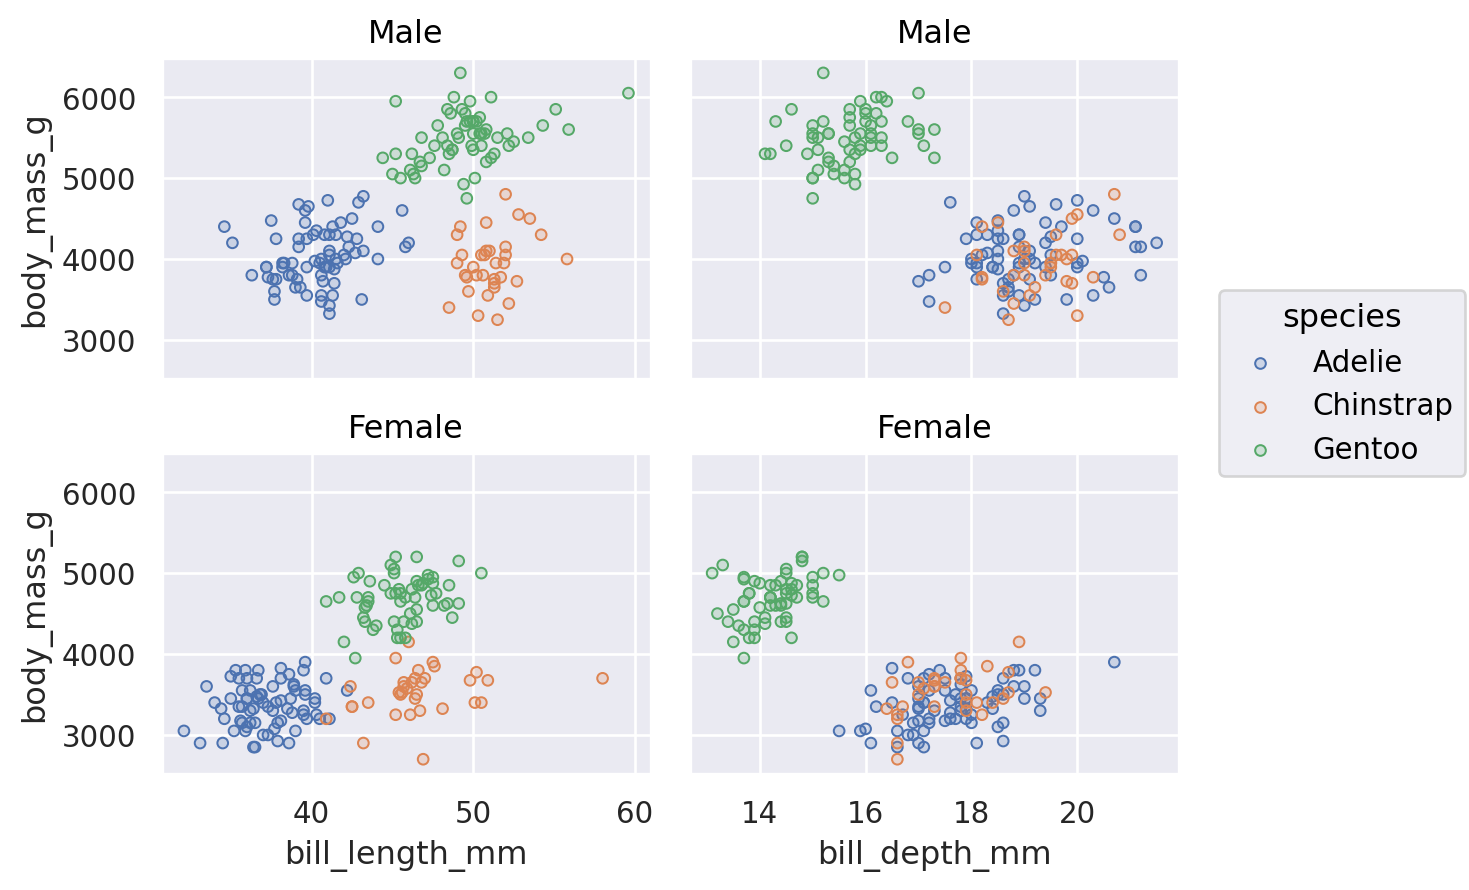

In [30]:
#Instantiate a faceted scatter plot of body mass vs bill dimensions, color mapped to species, faceted by sex
(
    so.Plot(penguins, y="body_mass_g", color="species") #dataframe, y axis and color mapping
    .pair(x=["bill_length_mm", "bill_depth_mm"]) #pairing x axis with bill length and depth
    .facet(row="sex")#faceting by sex
    .add(so.Dots()) #adding dot layer
)

## Integrating with matplotlib

There may be cases where you want multiple subplots to appear in a figure with a more complex structure than what `Plot.facet` or `Plot.pair` can provide. The current solution is to delegate figure setup to matplotlib and to supply the matplotlib object that `Plot` should use with the `Plot.on` method. This object can be either a `matplotlib.axes.Axes`, `matplotlib.figure.Figure`, or :`matplotlib.figure.SubFigure`; the latter is most useful for constructing bespoke subplot layouts:

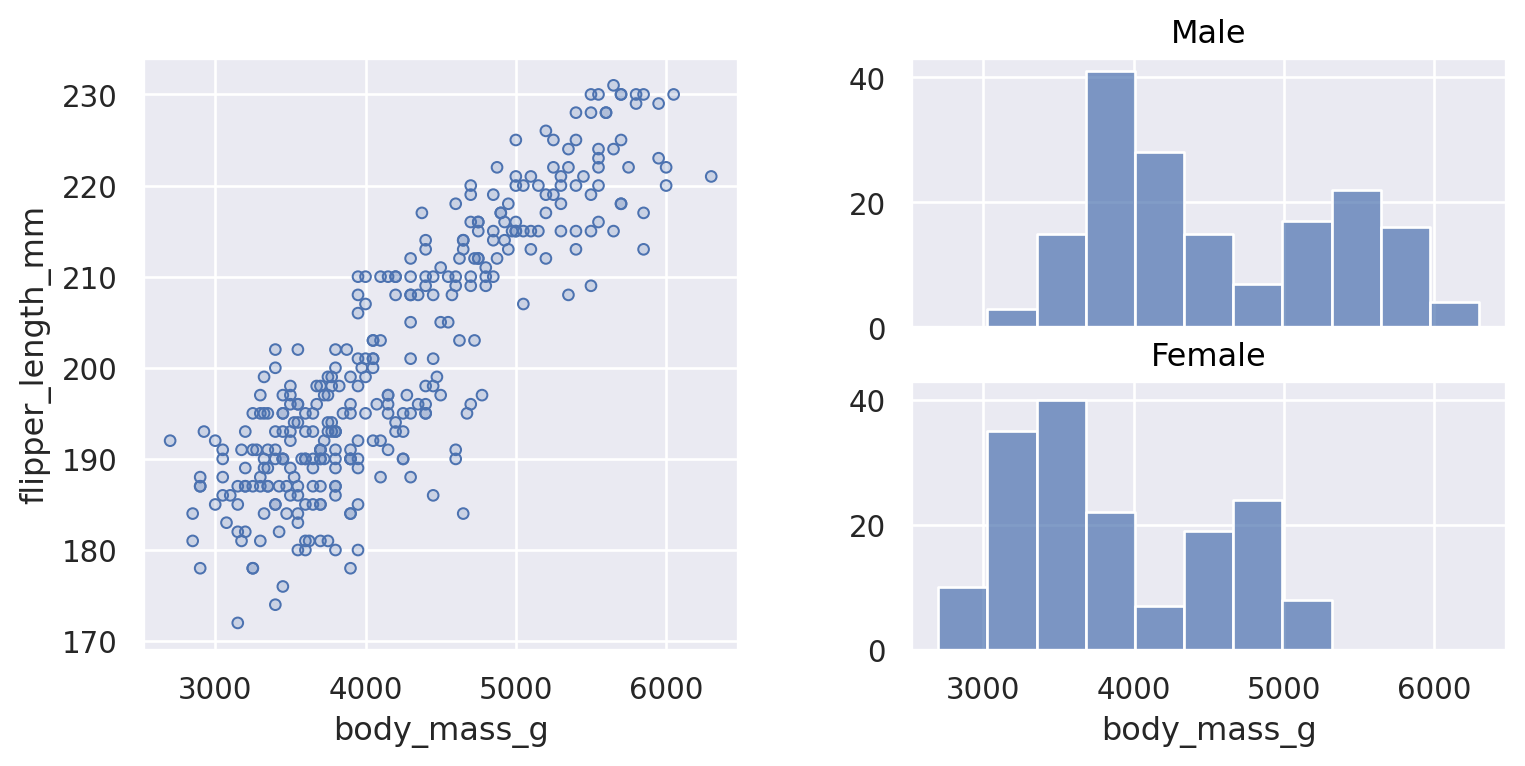

In [31]:
#Creating subfigures with matplotlib and plotting seaborn objects plots on them
f = mpl.figure.Figure(figsize=(8, 4)) #create a figure with specified size
sf1, sf2 = f.subfigures(1, 2) #create 1 row and 2 columns of subfigures, set them to variables sf1 and sf2
(#instantiate plots on the subfigures
    so.Plot(penguins, x="body_mass_g", y="flipper_length_mm") #dataframe, x and y axes
    .add(so.Dots()) #adding dot layer
    .on(sf1)#assigning plot to subfigure 1
    .plot()#displaying the plot, must call the plot() method to render the plot
)
(#instantiate plots on the subfigures
    so.Plot(penguins, x="body_mass_g") #dataframe, x axis only
    .facet(row="sex") #faceting by sex
    .add(so.Bars(), so.Hist()) #adding bar layer with histogram aggregation
    .on(sf2)#assigning plot to subfigure 2
    .plot() #displaying the plot, must call the plot() method to render the plot
)

## Building and displaying the plot

An important thing to know is that `Plot` methods clone the object they are called on and return that clone instead of updating the object in place. This means that you can define a common plot spec and then produce several variations on it.

So, take this basic specification:

In [32]:
#instantiate a plot object for healthexp dataset, assign to variable p
p = so.Plot(healthexp, "Year", "Spending_USD", color="Country")

We could use it to draw a line plot:

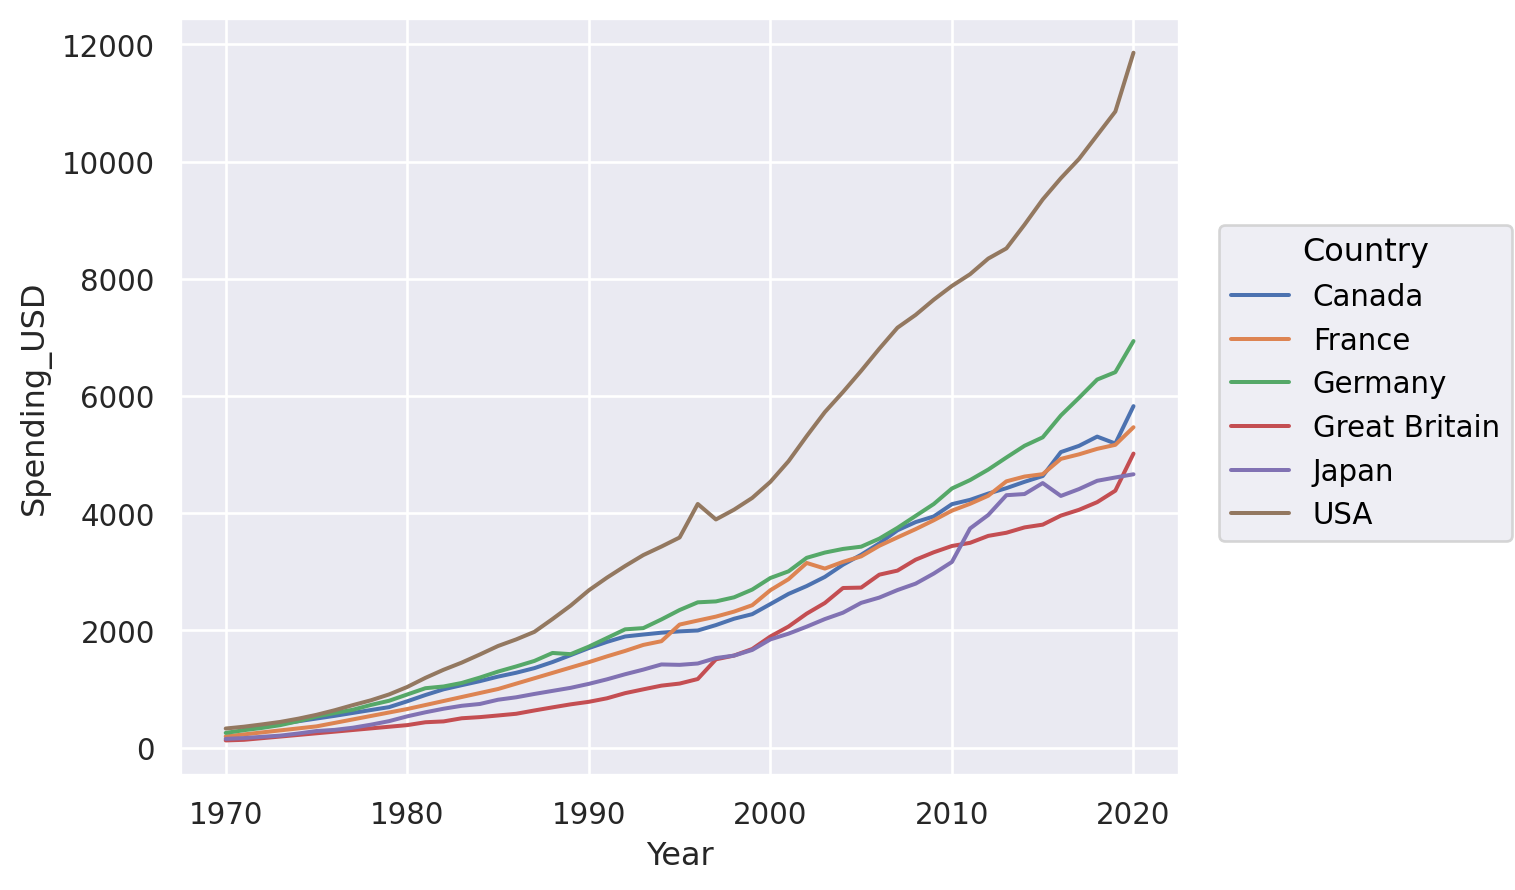

In [33]:
p.add(so.Line()) #adding a line layer   

Or perhaps a stacked area plot:

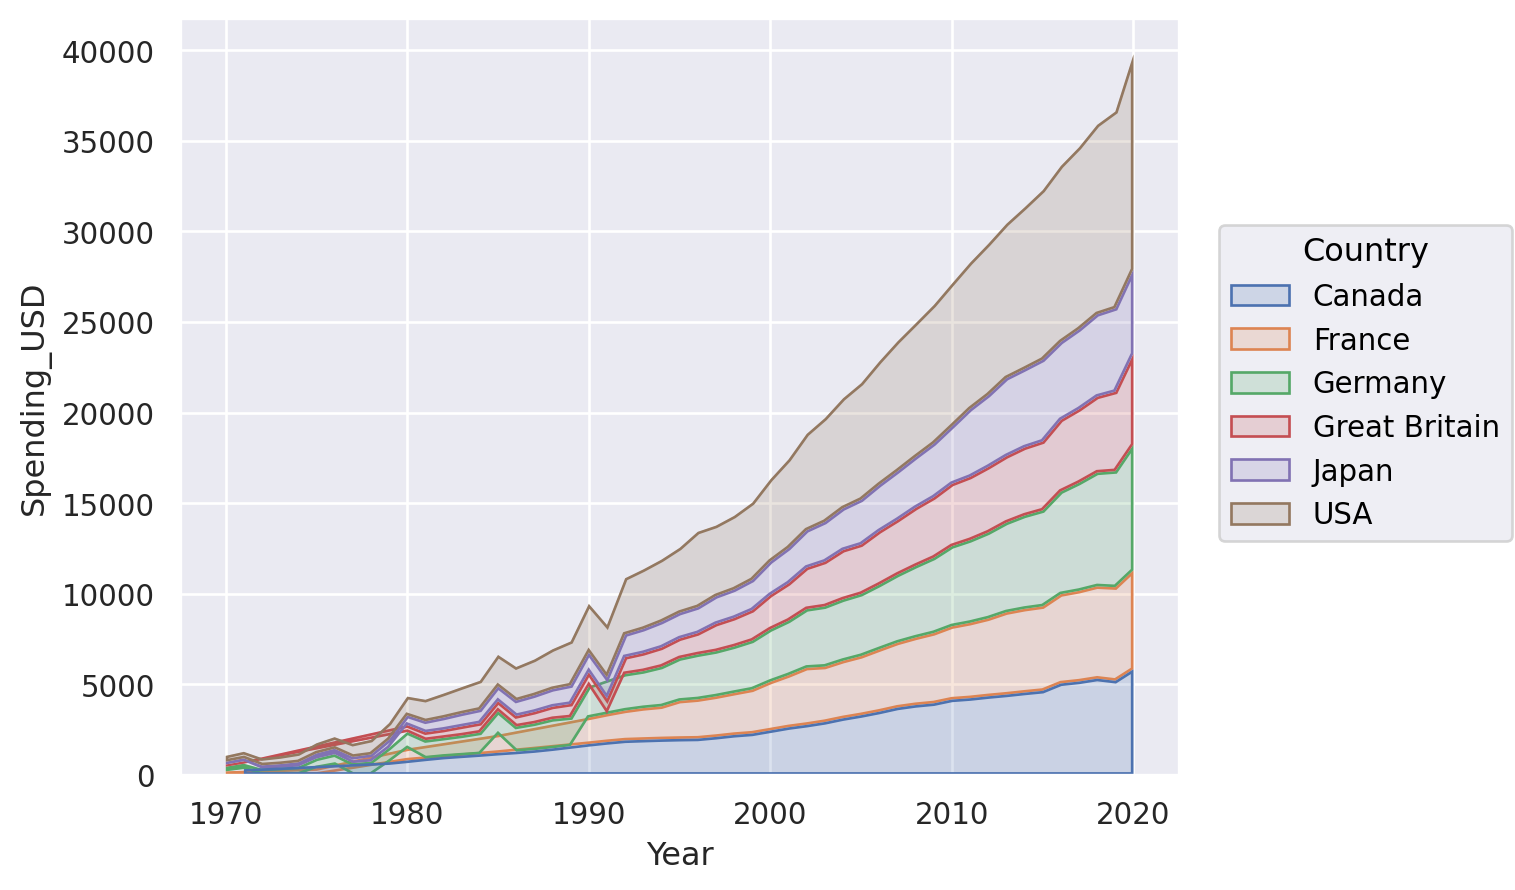

In [34]:
p.add(so.Area(), so.Stack()) #adding an area layer with stacking

The `Plot` methods are fully declarative. Calling them updates the plot spec, but it doesn't actually do any plotting. One consequence of this is that methods can be called in any order, and many of them can be called multiple times.

When does the plot actually get rendered? `Plot` is optimized for use in notebook environments. The rendering is automatically triggered when the `Plot` gets displayed in the Jupyter REPL. That's why we didn't see anything in the example above, where we defined a `Plot` but assigned it to `p` rather than letting it return out to the REPL.

To see a plot in a notebook, either return it from the final line of a cell or call Jupyter's built-in `display` function on the object. The notebook integration bypasses `matplotlib.pyplot` entirely, but you can use its figure-display machinery in other contexts by calling `Plot.show`.

You can also save the plot to a file (or buffer) by calling `Plot.save`.

## Customizing the appearance
### Parameterizing scales

All of the data-dependent properties are controlled by the concept of a `Scale` and the `Plot.scale` method. This method accepts several different types of arguments. One possibility, which is closest to the use of scales in matplotlib, is to pass the name of a function that transforms the coordinates:

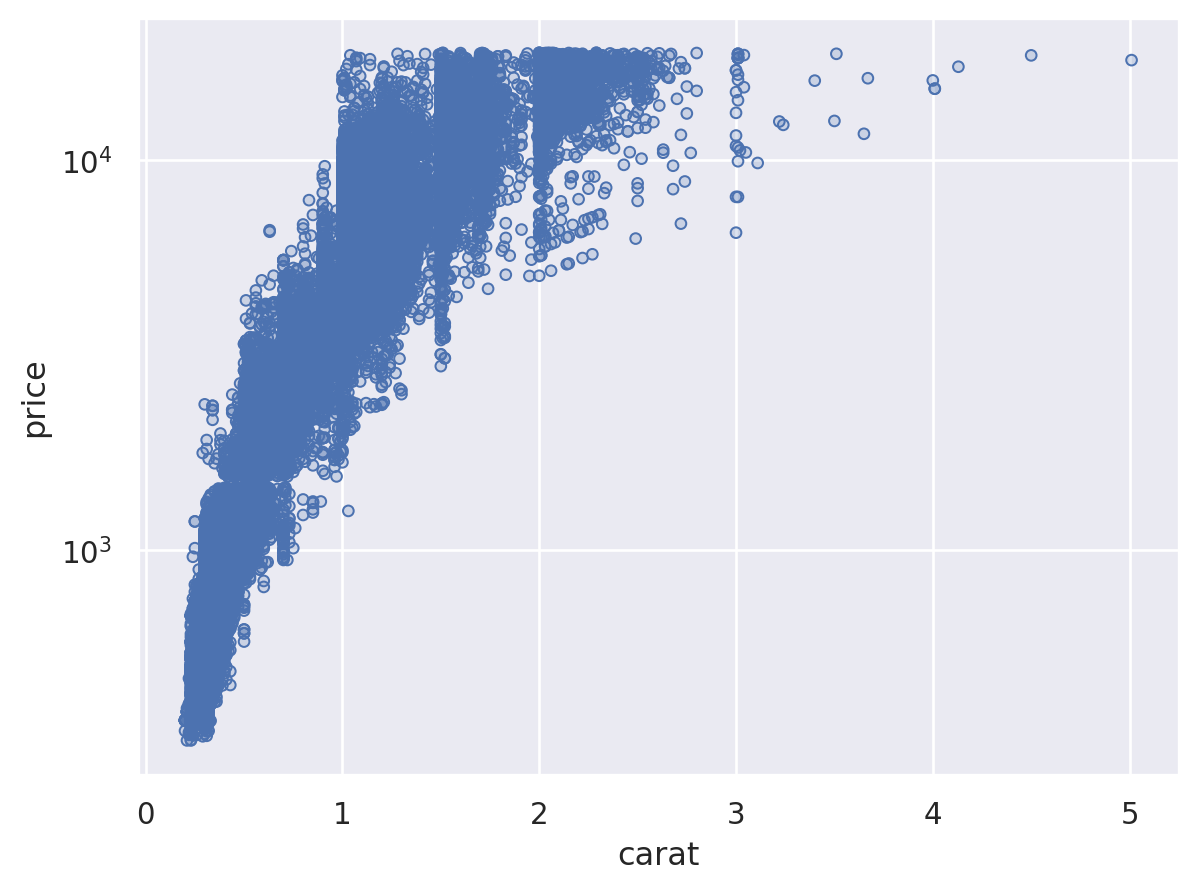

In [35]:
#Instantiate a scatter plot of diamond carat vs price with log scale on y axis
(
    so.Plot(diamonds, x="carat", y="price") #dataframe, x and y axes
    .add(so.Dots()) #adding dot layer
    .scale(y="log") #setting y axis to log scale
)

`Plot.scale` can also control the mappings for semantic properties like `color`. You can directly pass it any argument that you would pass to the `palette` parameter in seaborn's function interface:

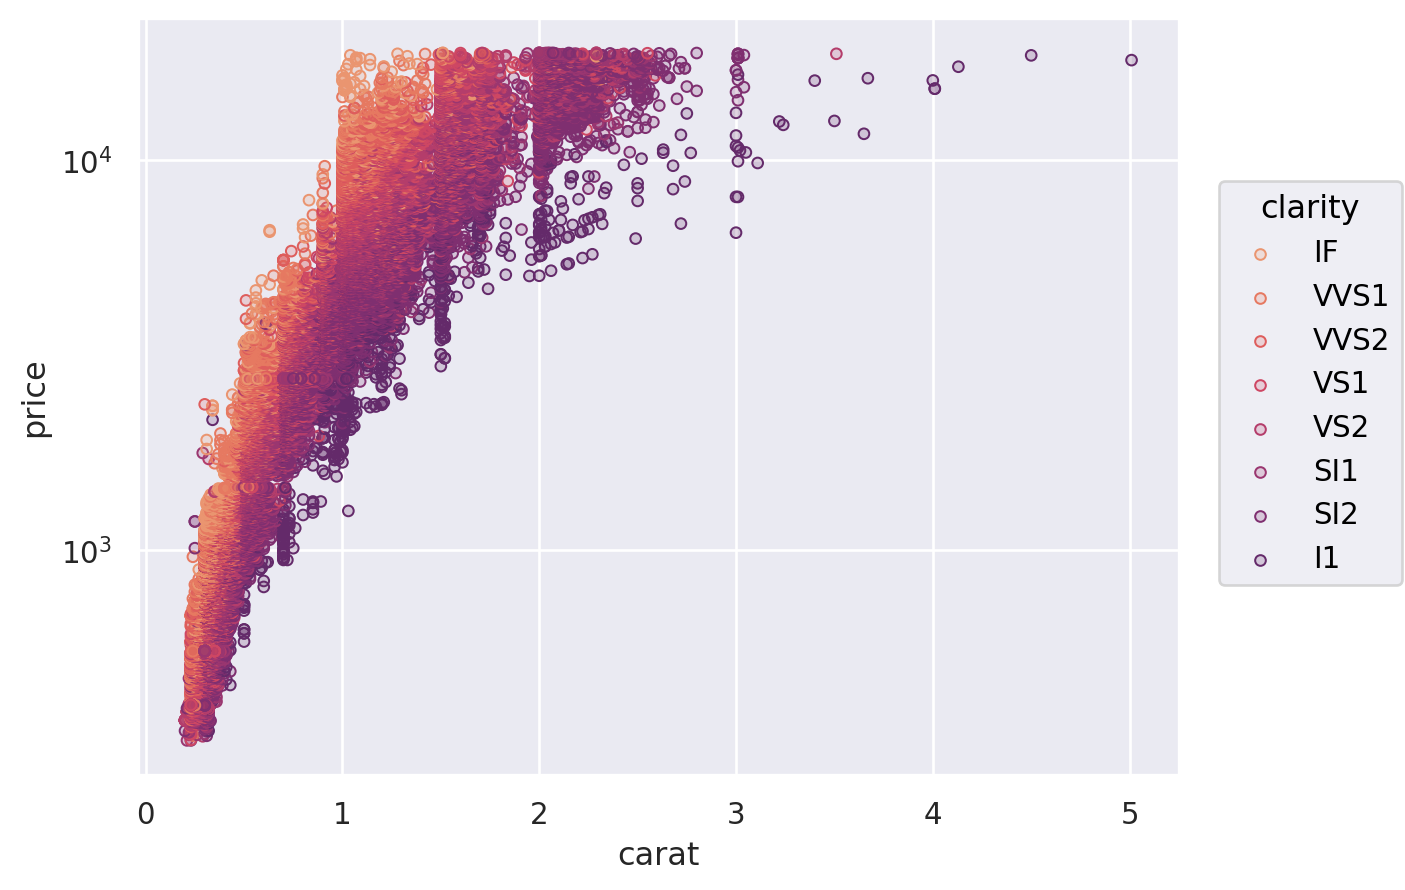

In [36]:
#Instantiate a scatter plot of diamond carat vs price, color mapped to clarity, with flare color scale
(
    so.Plot(diamonds, x="carat", y="price", #dataframe, x and y axes,
            color="clarity") # color mapped to clarity
    .add(so.Dots()) #adding dot layer
    .scale(y='log', color="flare") #setting color scale to flare
)

Another option is to provide a tuple of `(min, max)` values, controlling the range that the scale should map into. This works both for numeric properties and for colors:

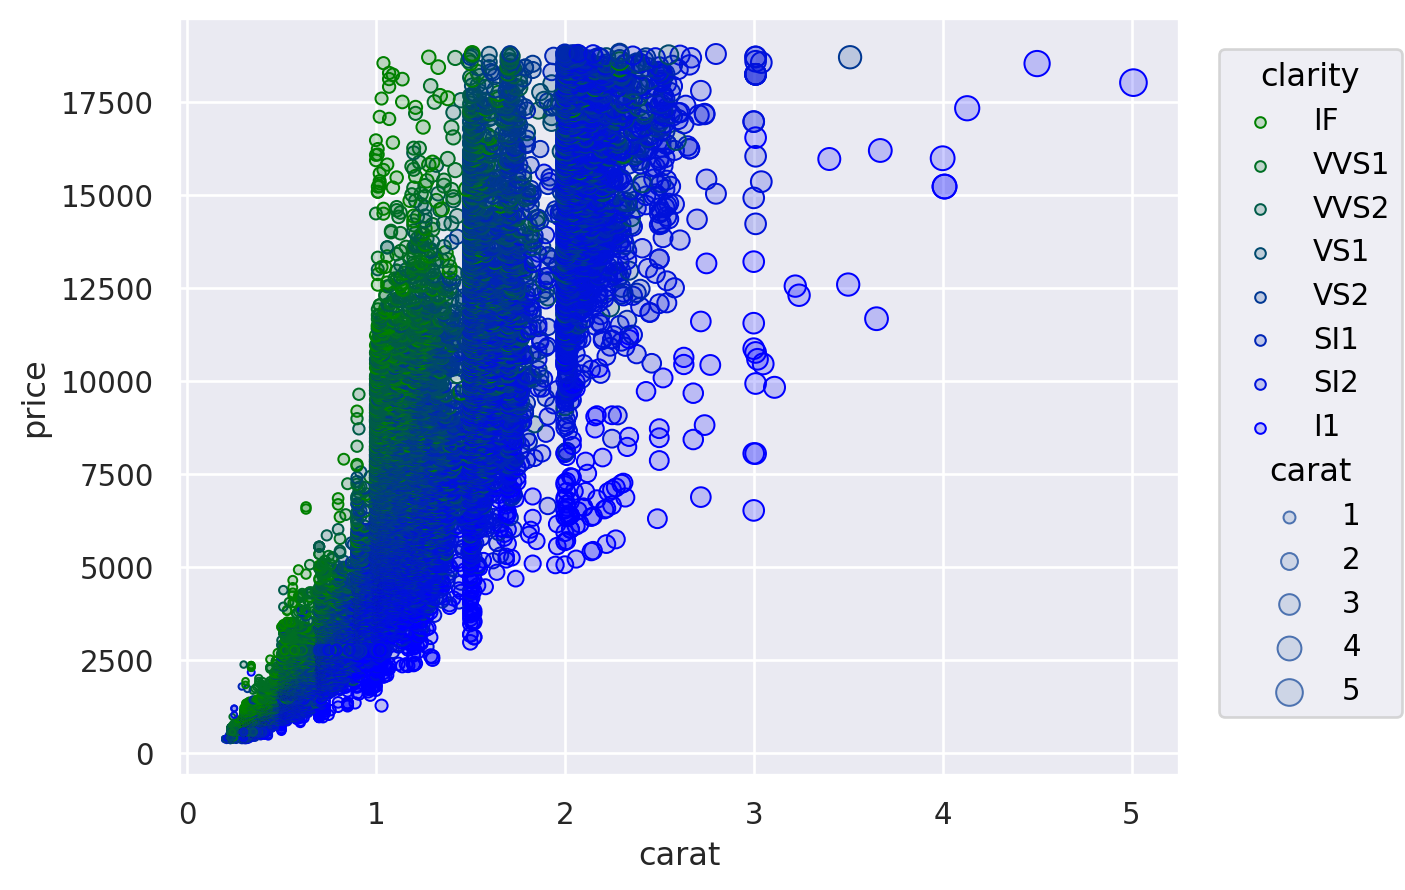

In [37]:
#Instantiate a scatter plot of diamond carat vs price, color mapped to clarity, with custom color and pointsize scales
(
    so.Plot(diamonds, x="carat", y="price", #dataframe, x and y axes,
            color="clarity", #color mapped to clarity
            pointsize="carat") #point size mapped to carat
    .add(so.Dots()) #adding dot layer
    .scale(color=("green", "blue"), pointsize=(2, 10)) #custom color scale from green to blue, point size scale from 2 to 10
)

For additional control, you can pass a `Scale` object. There are several different types of `Scale`, each with appropriate parameters. For example, `Continuous` lets you define the input domain (`norm`), the output range (`values`), and the function that maps between them (`trans`), while `Nominal` allows you to specify an ordering:

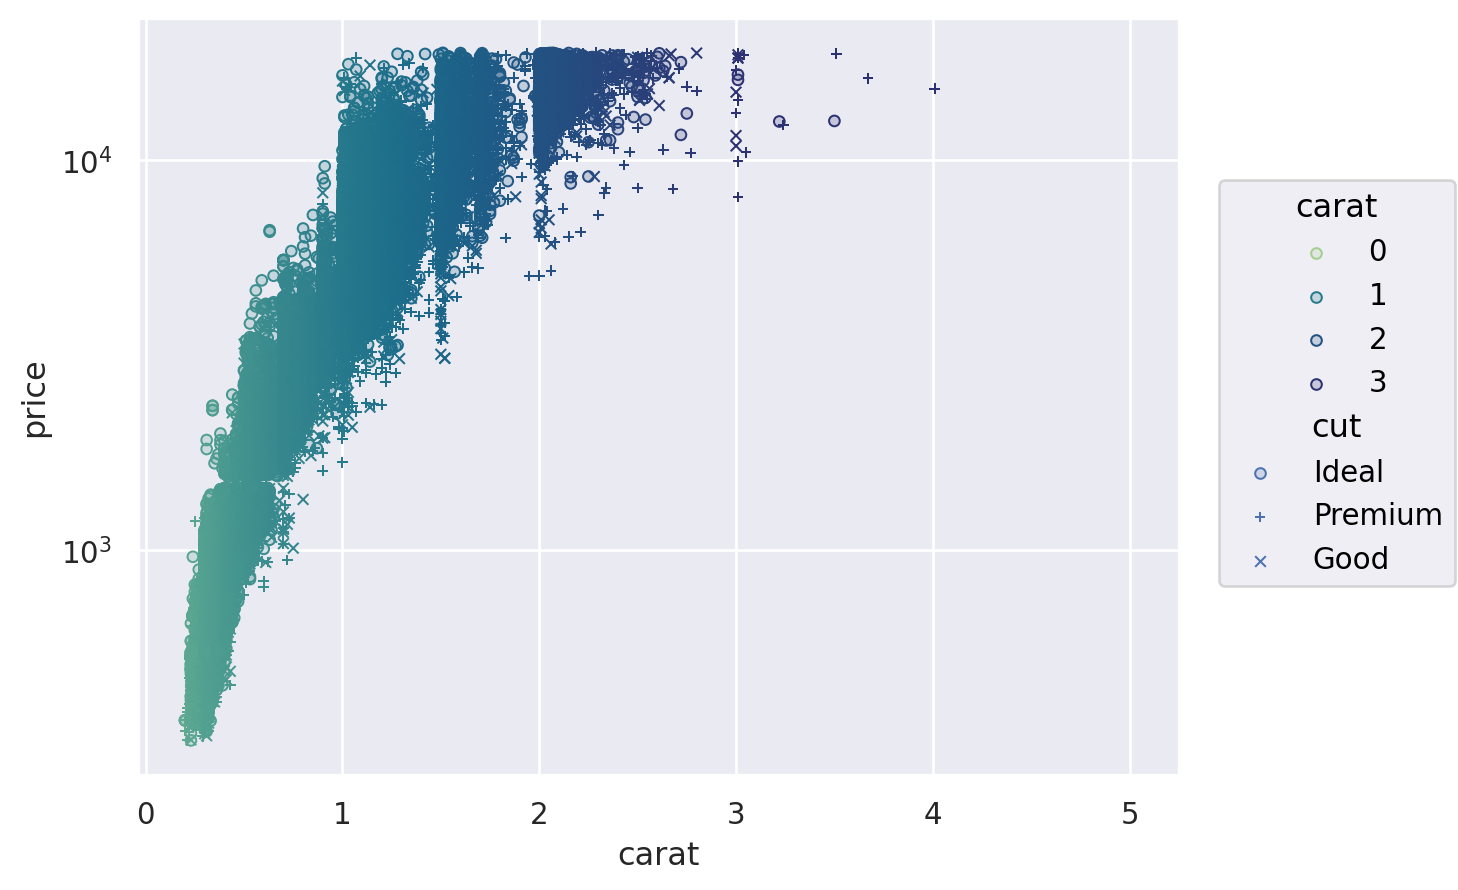

In [39]:
#Instantiate a scatter plot of diamond carat vs price, color mapped to carat, marker shape mapped to cut, with custom color and marker scales
(
    so.Plot(diamonds, x="carat", y="price", #dataframe, x and y axes,
            color="carat", marker="cut") #color mapped to carat, marker shape mapped to cut
    .add(so.Dots()) #adding dot layer
    .scale( y='log', #setting y axis to log scale
        color=so.Continuous("crest", norm=(0, 3), trans="sqrt"), #custom continuous color scale with crest palette, normalization and square root transformation
        marker=so.Nominal(["o", "+", "x"], order=["Ideal", "Premium", "Good"]), #custom nominal marker scale with specified order
    )
)

## Customizing legends and ticks

The `Scale` objects are also how you specify which values should appear as tick labels / in the legend, along with how they appear. For example, the `Continuous.tick` method lets you control the density or locations of the ticks, and the `Continuous.label` method lets you modify the format:

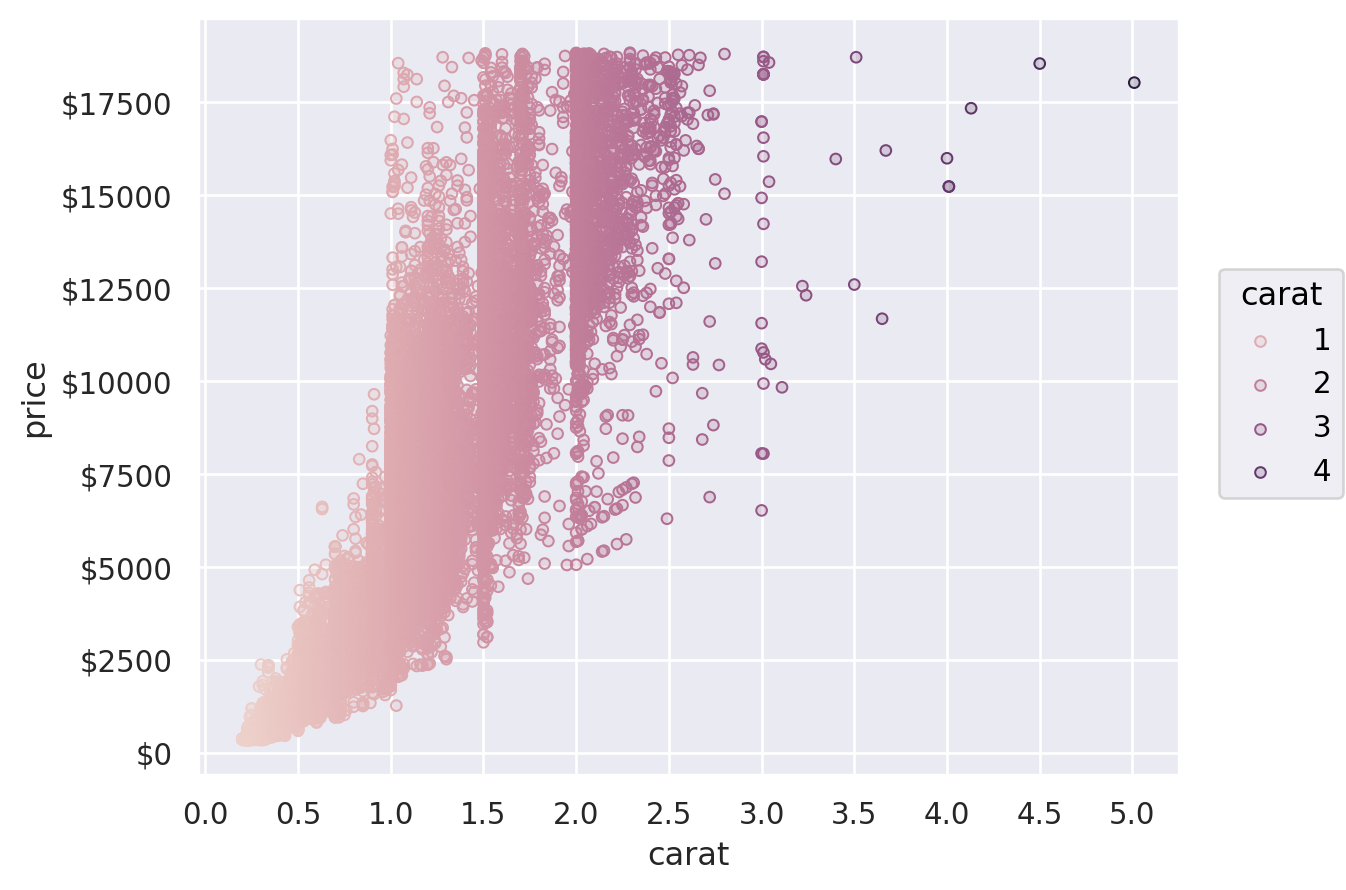

In [41]:
#Instantiate a scatter plot of diamond carat vs price, color mapped to carat, with custom axis ticks and labels
(
    so.Plot(diamonds, x="carat", y="price", color="carat") #dataframe, x and y axes, color mapped to carat
    .add(so.Dots()) #adding dot layer
    .scale(  #customizing axis scales, 
        x=so.Continuous().tick(every=0.5), #custom x axis ticks every 0.5 units
        y=so.Continuous().label(like="${x:.0f}"), #custom y axis labels in dollar format with no decimal places
        color=so.Continuous().tick(at=[1, 2, 3, 4]), #custom color scale ticks at specified values
    )
)

## Customizing limits, labels, and titles

`Plot` has a number of methods for simple customization, including `Plot.label`, `Plot.limit`, and `Plot.share`:

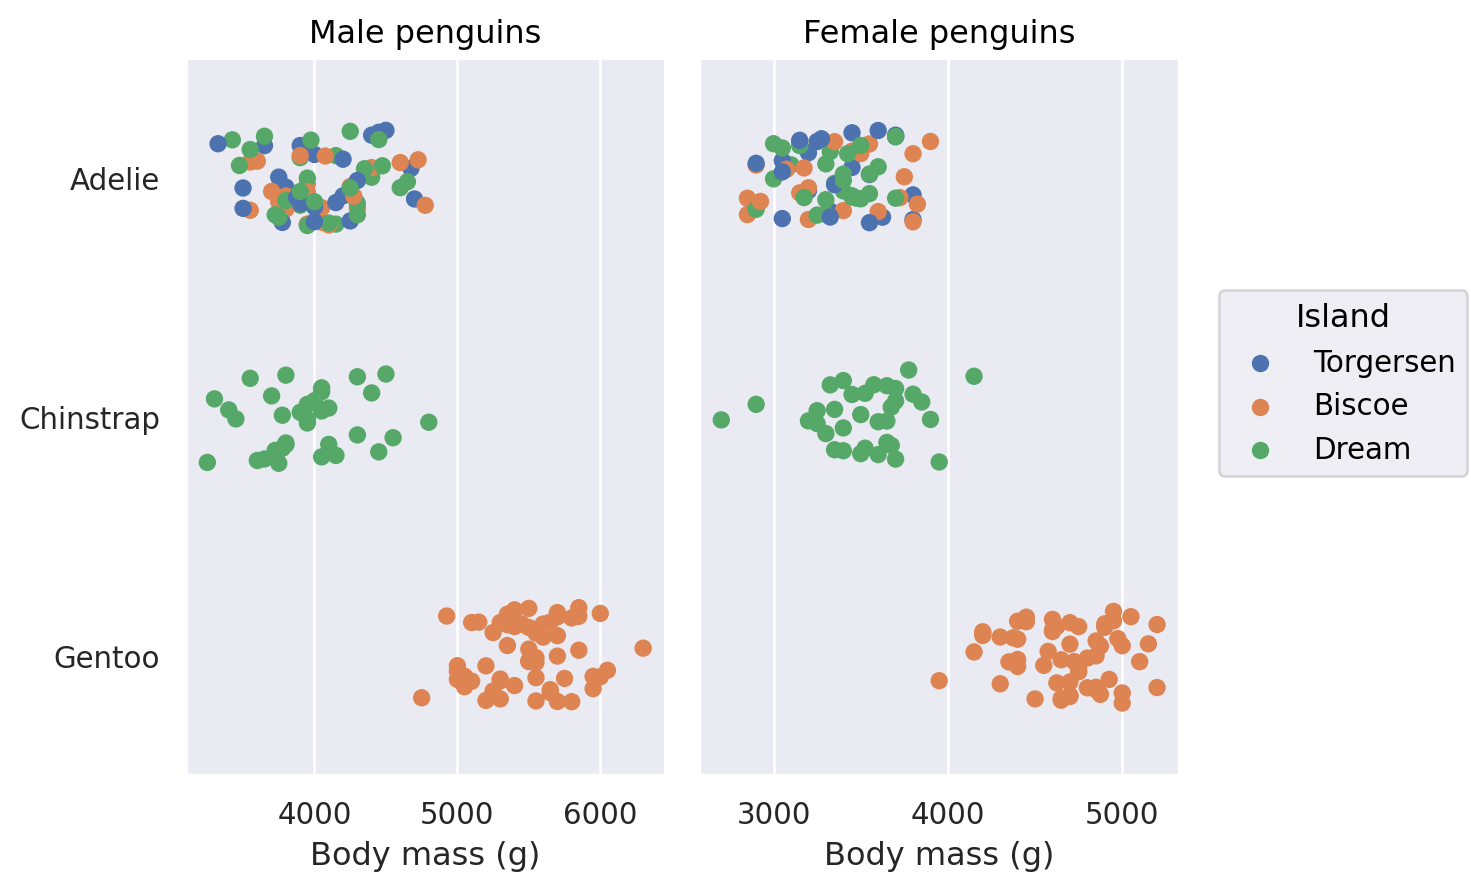

In [43]:
#Instantiate a scatter plot of body mass vs species, color mapped to island, faceted by sex
(
    so.Plot(penguins, x="body_mass_g", y="species",  #setting dataframe, x and y axes
            color="island") #mapping color to island
    .facet(col="sex") #faceting by sex
    .add(so.Dot(), so.Jitter(.5)) #adding dot layer with jitter to spread points
    .share(x=False) #disable shared x axis across facets
    .limit(y=(2.5, -.5)) #custom y axis limits
    .label(
        x="Body mass (g)", y="", #x and y axis labels
        color=str.capitalize, #capitalize color legend labels
        title="{} penguins".format, #custom title with format string, custom comes from the {} placeholder
    )
)

## Theme customization

`Plot` supports data-independent theming through the `Plot.theme` method. Currently, this method accepts a dictionary of matplotlib rc parameters. You can set them directly and/or pass a package of parameters from seaborn's theming functions:

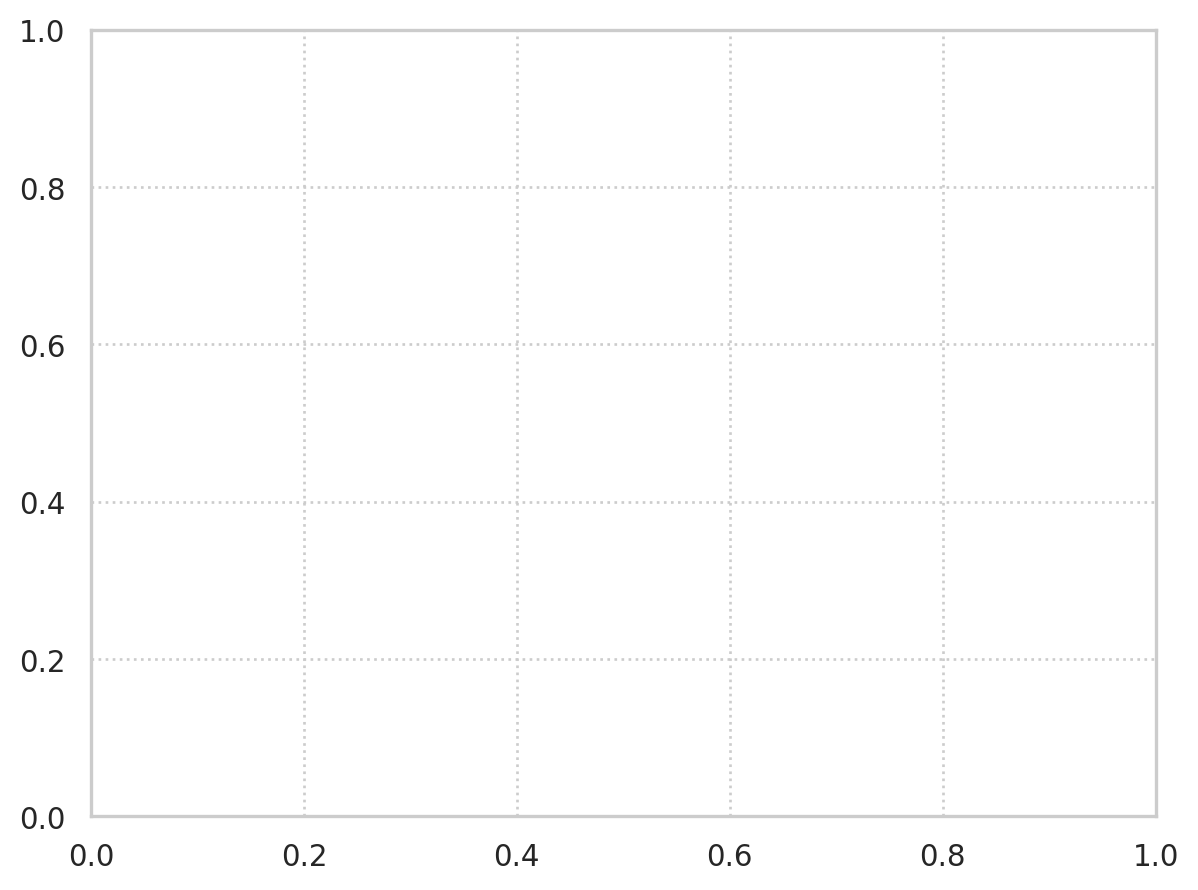

In [44]:
from seaborn import axes_style
theme_dict = {**axes_style("whitegrid"), "grid.linestyle": ":"}
so.Plot().theme(theme_dict)

To change the theme for all `Plot` instances, update the settings in `Plot.config`:

In [45]:
so.Plot.config.theme.update(theme_dict)

Now that we learned the objects methods, lets transition to the [visualizing Statistical Relationships](./relational.ipynb)